# 1. Cleaning data

### Data import

From the ``/data/Train2/files.csv`` we import all the time series recorded in the df list. Each entry of df, df[i] is a Pandas DataFrame with columns ``x, y, z, t``. 

The labels are replaced according to the three categories and stored in a list.

In [2]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
from scipy import interpolate
from ipywidgets import interact, IntSlider, Layout

# Creating list of Pandas Dataframes
df_list = []

# Read class data
data = pd.read_csv('../data/files.csv')

# Loop through each file in the Train2 directory and append the data to df_list
i = 0
for filename in data['folder']:
    df_list.append(pd.read_csv(os.path.join('../data/Train2',
                   filename), header=None, names=['x', 'y', 'z', 'time']))
    i = i + 1

# Replace the original class labels with new labels for classification with 8 classes
# labels = data['class'].replace([1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,6,6,7,8])
# activities = ['walking', 'running', 'jumping','walking_down', 'walking_up', 'falling','lying','other']

# Replace the original class labels with new labels for classification with 10 classes
labels = data['class']
activities = ['walking', 'running', 'jumping','walking_down', 'walking_up', 'forward falling','sideways falling','backward falling','lying','other']


### Missing values
We verify that there are no missing values

In [3]:
# Check for missing values in each dataframe in df_list
missing_values = False
for df in df_list:
    if df.isnull().values.any():
        missing_values = True
        break

# Print a message if there are missing values
if missing_values:
    print('There are missing values in at least one dataframe')
else:
    print('There are no missing values in any dataframe')


There are no missing values in any dataframe


### Sampling time

Before moving on, we focused on the timestep. According to official documentation, the sampling frequency of the accelerometer should be the same for all registration. Many features extracted may rely and be greatly simplified by having a homogeneus timestep

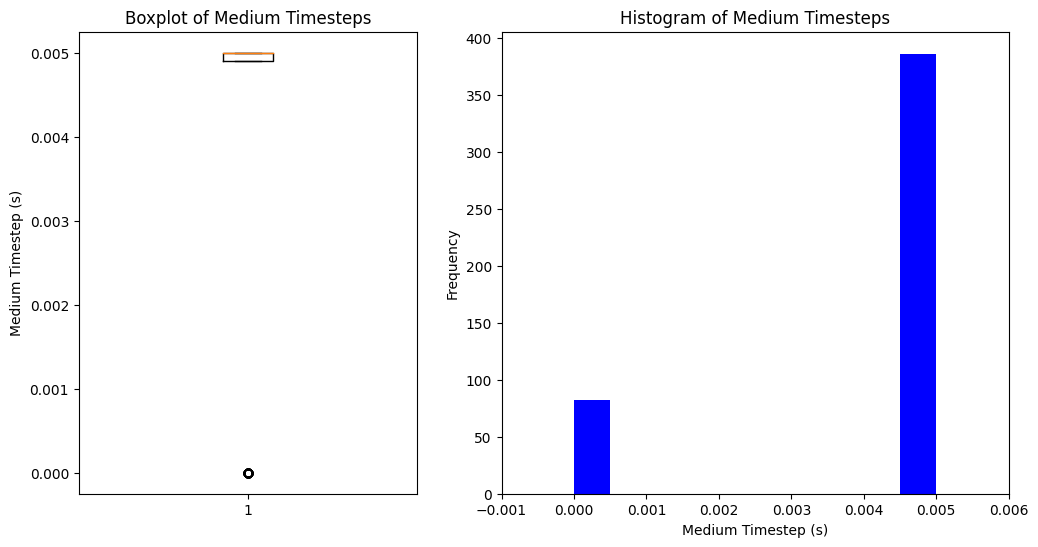

In [4]:
# Create a list to store the medium timestep for each dataframe
medium_timesteps = []

# Loop through each dataframe in df_list and calculate the medium timestep
for i, df in enumerate(df_list):
    medium_timestep = df['time'].diff().median()
    medium_timesteps.append(medium_timestep)

# Create a list to store the medium timestep for each dataframe
medium_timesteps = []

# Loop through each dataframe in df_list and calculate the medium timestep
for i, df in enumerate(df_list):
    medium_timestep = df['time'].diff().median()
    medium_timesteps.append(medium_timestep)


# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(
    12, 6), gridspec_kw={'width_ratios': [2, 3]})

# Create a boxplot of the medium timesteps
ax1.boxplot(medium_timesteps)
ax1.set_title('Boxplot of Medium Timesteps')
ax1.set_ylabel('Medium Timestep (s)')

# Create a histogram of the medium timesteps
ax2.hist(medium_timesteps, bins=10, color='blue')
ax2.set_title('Histogram of Medium Timesteps')
ax2.set_xlabel('Medium Timestep (s)')
ax2.set_ylabel('Frequency')
xticks = ax2.get_xticks()
xtick_labels = [f'{xtick:.2f}' for xtick in xticks]
ax2.set_xticks(xticks)
plt.show()


The sampling rate seems almost always coherent with what was defined on the documentation. 
There seems to be a few exceptions: in the data, time is always recorded with five digits **regardless of the number of decimal digits**.

Since starting time is not set to zeroes but varies accross observations, every observation with starting 
$\text{time} >10$ or $\text{time}>100$ will have respectively three or two digits decimal precision.

This means that some timeseries will have points recorded apparently at the same time:

In [5]:
print(df_list[np.argmin(medium_timesteps)]['time'][0:3])


0    103.47
1    103.47
2    103.48
Name: time, dtype: float64


We thus process the whole dataset using pre_process_data to shift the starting time to zero and register the correct sampling rate (200Hz) to the timeseries at fault

In [6]:
def pre_process_data(data_acc, fs):
    """
    This function interpolates the accelerometer and gyroscope data to the same time interval.

    Parameters
    ----------
    data_acc : nd-array
        Accelerometer data of specified activity
    fs : int
        Sampling frequency

    Returns
    -------
    Interpolated data (nd-array)
    """

    # Extract the time and accelerometer data from the input data
    time_acc = (data_acc.iloc[:, 3]) - data_acc.iloc[0, 3]
    data_act_acc = data_acc.iloc[:, 0:3]

    # Define the time interval for interpolation
    time_acc = np.array(time_acc)
    t0 = time_acc[0]
    tn = time_acc[-1]
    time_new = np.linspace(t0, tn, int((tn - t0) / ((1 / fs))))

    # Interpolate the accelerometer data
    data_act_acc = np.array(data_act_acc)
    acc_data = np.array([interpolate.interp1d(time_acc, data_act_acc[:, ax])(
        time_new) for ax in range(np.shape(data_act_acc)[1])]).T

    # Concatenate the interpolated data and the new time array
    data = np.column_stack((acc_data, time_new))
    data = pd.DataFrame(data, columns=['x', 'y', 'z', 'time'])

    return data


def plot_data(data):
    """This function plots the accelerometer and gyroscope data.

    Parameters
    ----------
    data nd-array
    Interpolated data

    Returns
    -------
    None

    """
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0, 0].plot(data['time'], data['x'])
    axs[0, 0].set_title('X Acceleration')
    axs[0, 1].plot(data['time'], data['y'])
    axs[0, 1].set_title('Y Acceleration')
    axs[1, 0].plot(data['time'], data['z'])
    axs[1, 0].set_title('Z Acceleration')
    for ax in axs.flat:
        ax.set(xlabel='Time (s)', ylabel='Acceleration (m/s^2)')
    plt.show()


In [7]:
for i in range(len(df_list)):
    df_list[i] = pre_process_data(df_list[i], 200)


In [8]:
print(df_list[np.argmin(medium_timesteps)]['time'][0:3])


0    0.000000
1    0.005007
2    0.010013
Name: time, dtype: float64


# 2. Data visualization

Now that the data is cleaned, let's take a look at the dataset

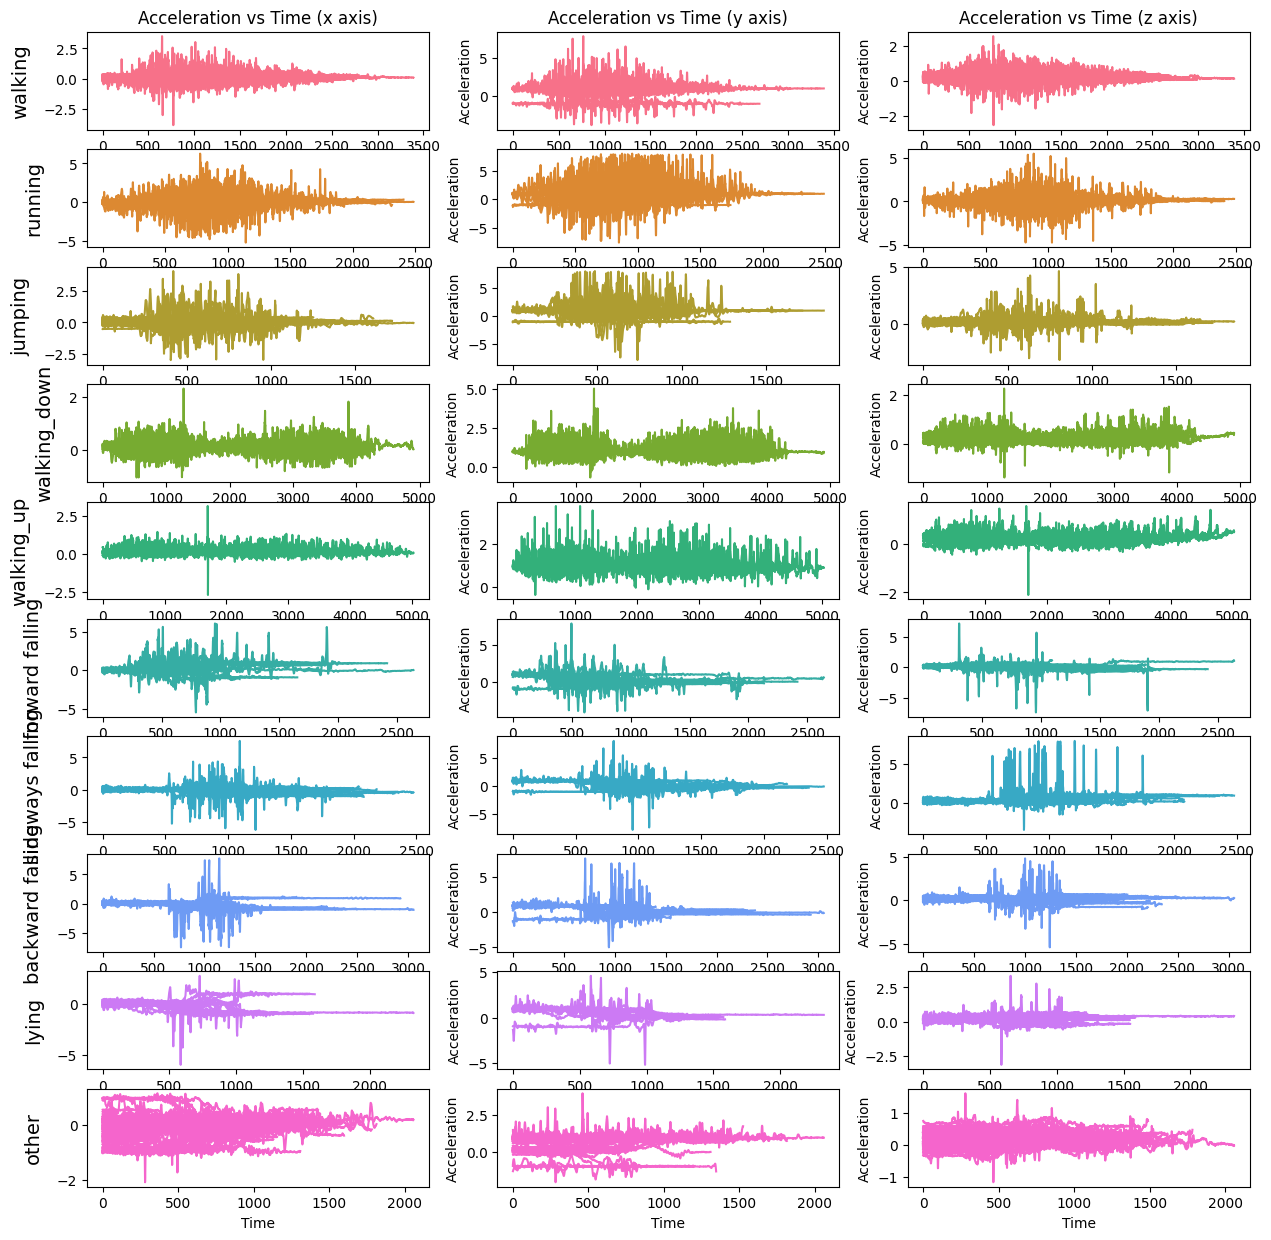

In [9]:
# Define a color palette
palette = sns.color_palette('husl', n_colors=len(activities))

# Create a color dictionary
color_dict = dict(zip(range(1, len(activities)+1), palette))
# Create a figure with three subplots
fig, axs = plt.subplots(len(activities), 3, figsize=(15, 1.5*len(activities)))

# Plot the data in each subplot
for i, df in enumerate(df_list):
    for j, col in enumerate(df.columns[:-1]):
        activity_type = labels[i]
        axs[activity_type-1][j].plot(df[col], color=color_dict[labels[i]])
        axs[activity_type-1][j].set_xlabel('Time')
        axs[activity_type-1][j].set_ylabel('Acceleration')

        axs[0][j].set_title(
            f'Acceleration vs Time ({["x", "y", "z"][j]} axis)')

    axs[activity_type-1][0].set_ylabel(
        f'{activities[activity_type-1]}', fontsize=14, rotation=90, labelpad=10)
    axs[activity_type-1][1].set_ylabel('Acceleration')
    axs[activity_type-1][2].set_ylabel('Acceleration')


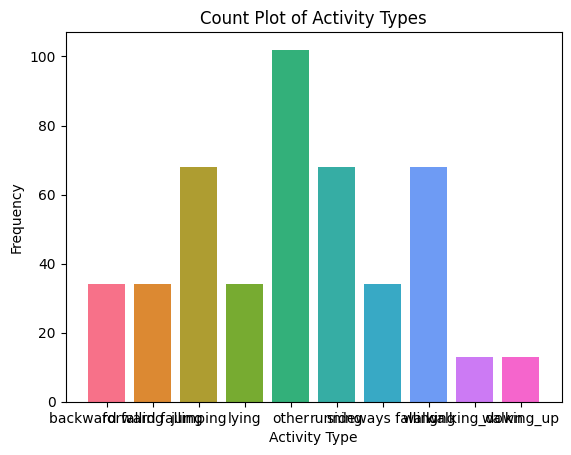

In [10]:
# Class distribution
# Calculate the unique values and their frequencies
text_labels = labels.replace(range(1, len(activities)+1), activities)
unique_values, frequencies = np.unique(text_labels, return_counts=True)

# Plotting the count plot
plt.bar(unique_values, frequencies, color=color_dict.values())
plt.xlabel('Activity Type')
plt.ylabel('Frequency')
plt.title('Count Plot of Activity Types')
plt.show()


# 3. Feature Extraction and Visualization

It's time to extract the numerical feature from our dataset to analyze it. In order to do this, we brainstormed as many relevant feature as possible to calculate that could be relevant for our problem. We identified three macro areas:

1. Basic Statistical Measures (min, max, std, ...)
2. Time Series Analysis inspired measures (turning points, zero cross count, autocorrelation, ...)
3. Signal Processing inspired measures (AUC, Peak to Peak distance, ...)

Below is the complete list, consisting of 24 features, each one extracted from each of the time series of the observation (x,y,z axis), for a total of 72 features.

The features functions and how they are calcolated are into the ``/features.py`` file. The function below calculates the feature for every observation of the df_list and append a row with the features to tsfeat.

| Statistical Measures                    | Time Series Analysis                                                                                                                                                                                                                              | Signal Processing                                       |
|-----------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------|
| Max, Min, Mean,  Median, Std,  Variance | Kurtosis,  Mean Absolute Deviation, Mean (Absolute) Difference,  Median Absolute Deviation, Median (Absolute) Difference, Slope,  Sum Absolute Difference, Zero Cross Count | Area Under Curve,  Peak to Peak distance,  Total Energy, Fundamental Frequency |

In [11]:
# Import the Features class and the inspect module
from features import Features
import inspect

# Define a function to calculate features for each signal in a dataframe


def calc_features(df):

    f = Features()

    # Get a list of all the methods of the Features object
    attrs = (getattr(f, name) for name in dir(f))
    methods = filter(inspect.ismethod, attrs)

    # Create an empty dataframe to store the features
    df_features = pd.DataFrame()

    # Loop through each signal in the dataframe
    for signals in df:
        # Create empty lists to store the feature names and values
        names = []
        values = []

        # Loop through each column in the signal [x, y, z]
        for columns in signals.columns[:-1]:
            # Get the signal data as a numpy array
            signal = np.array(signals[columns])

            # Create a Features object
            f = Features()
            attrs = (getattr(f, name) for name in dir(f))
            methods = filter(inspect.ismethod, attrs)

            # Loop through each method and calculate the feature value
            for method in methods:
                # Append the feature name and value to the lists
                names.append(method.__name__ + '_' + columns)
                values.append(getattr(f, method.__name__)(signal))

        # Create a new dataframe with the feature values and names as columns
        df_new = pd.DataFrame(values, index=names).T

        # Concatenate the new dataframe with the existing dataframe
        if df_features.empty:
            df_features = df_new
        else:
            df_features = pd.concat([df_features, df_new])

    # Return the dataframe of features
    return df_features


In [12]:
tsfeat = calc_features(df_list)
tsfeat.head()

,auc_x,calc_max_x,calc_mean_x,calc_median_x,calc_min_x,calc_std_x,calc_var_x,fundamental_frequency_x,kurtosis_x,mean_abs_deviation_x,...,mean_abs_diff_z,mean_diff_z,median_abs_deviation_z,median_abs_diff_z,median_diff_z,pk_pk_distance_z,slope_z,sum_abs_diff_z,total_energy_z,zero_cross_z
0,1.557371,0.693289,0.066696,0.061151,-0.784883,0.186931,0.034943,0.088574,3.513048,0.127187,...,0.014574,-0.000002,0.072863,0.008507,-0.000759,0.592104,-0.000002,32.922238,1.857917,98.0
0,2.171963,0.470244,-0.163410,-0.127067,-1.603301,0.266975,0.071276,0.994036,3.629878,0.183407,...,0.026098,-0.000022,0.081479,0.012172,0.001242,1.692158,-0.000028,52.561213,6.522787,96.0
0,3.710821,0.177058,-0.478372,-0.434809,-1.057066,0.436291,0.190350,0.131406,-1.817942,0.416833,...,0.010757,0.000191,0.061639,0.007102,0.000148,0.624218,0.000082,16.393202,19.311767,0.0
0,4.674279,0.281936,-0.454445,-0.090394,-4.354404,0.545581,0.297658,0.104058,5.179823,0.494704,...,0.014981,-0.000204,0.177410,0.006833,-0.000236,3.948470,-0.000239,28.823818,21.526363,10.0
0,1.229189,1.308709,0.255591,0.248850,-0.325685,0.177186,0.031395,0.217391,7.632506,0.105397,...,0.016062,-0.000151,0.055582,0.008076,0.000255,1.313669,-0.000026,14.809155,7.223184,20.0


In [13]:
tsfeat.columns[0:20]


Index(['auc_x', 'calc_max_x', 'calc_mean_x', 'calc_median_x', 'calc_min_x',
       'calc_std_x', 'calc_var_x', 'fundamental_frequency_x', 'kurtosis_x',
       'mean_abs_deviation_x', 'mean_abs_diff_x', 'mean_diff_x',
       'median_abs_deviation_x', 'median_abs_diff_x', 'median_diff_x',
       'pk_pk_distance_x', 'slope_x', 'sum_abs_diff_x', 'total_energy_x',
       'zero_cross_x'],
      dtype='object')

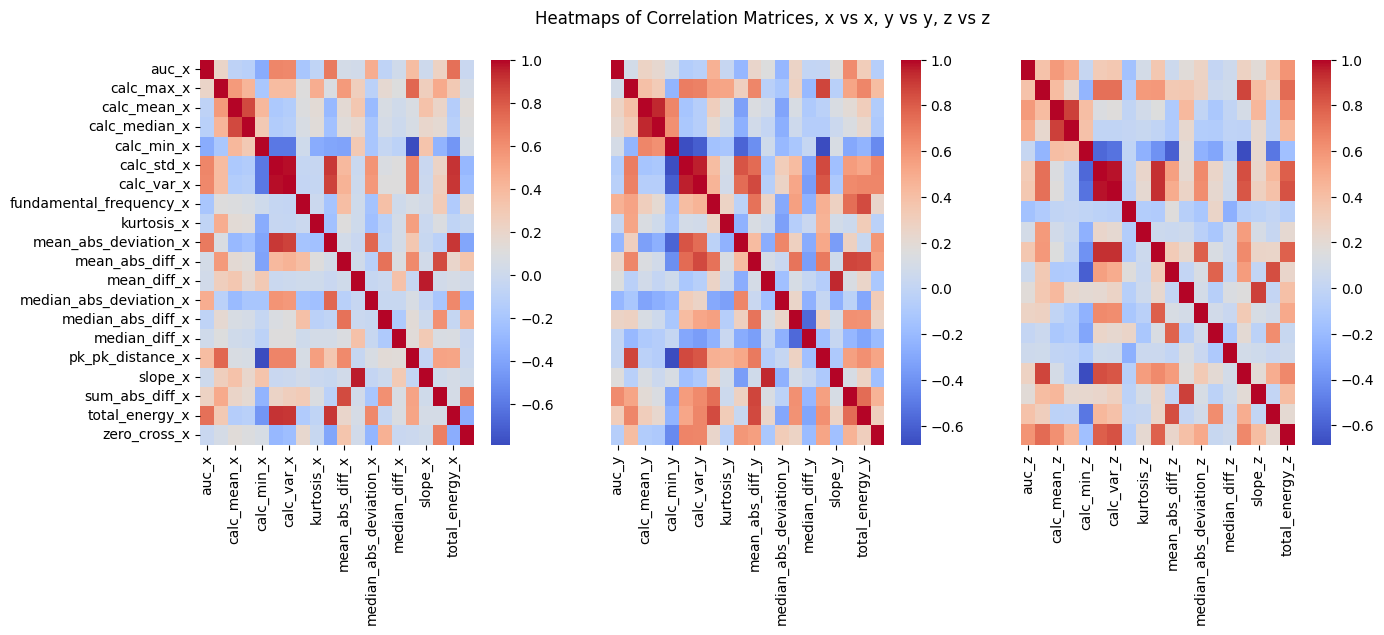

In [14]:
method_list = [func for func in dir(Features) if callable(
    getattr(Features, func)) and not func.startswith("__")]

# Calculate the correlation matrices
corr_matrix1 = tsfeat.iloc[:, :len(method_list)].corr()
corr_matrix2 = tsfeat.iloc[:, len(method_list):len(method_list)*2].corr()
corr_matrix3 = tsfeat.iloc[:, len(method_list)*2:-1].corr()

# Create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Create a heatmap in each subplot
sns.heatmap(corr_matrix1, cmap='coolwarm',  ax=axes[0])
sns.heatmap(corr_matrix2, cmap='coolwarm',  ax=axes[1], yticklabels=False)
sns.heatmap(corr_matrix3, cmap='coolwarm',  ax=axes[2], yticklabels=False)

# Set the title of the plot
fig.suptitle('Heatmaps of Correlation Matrices, x vs x, y vs y, z vs z')

# Show the plot
plt.show()


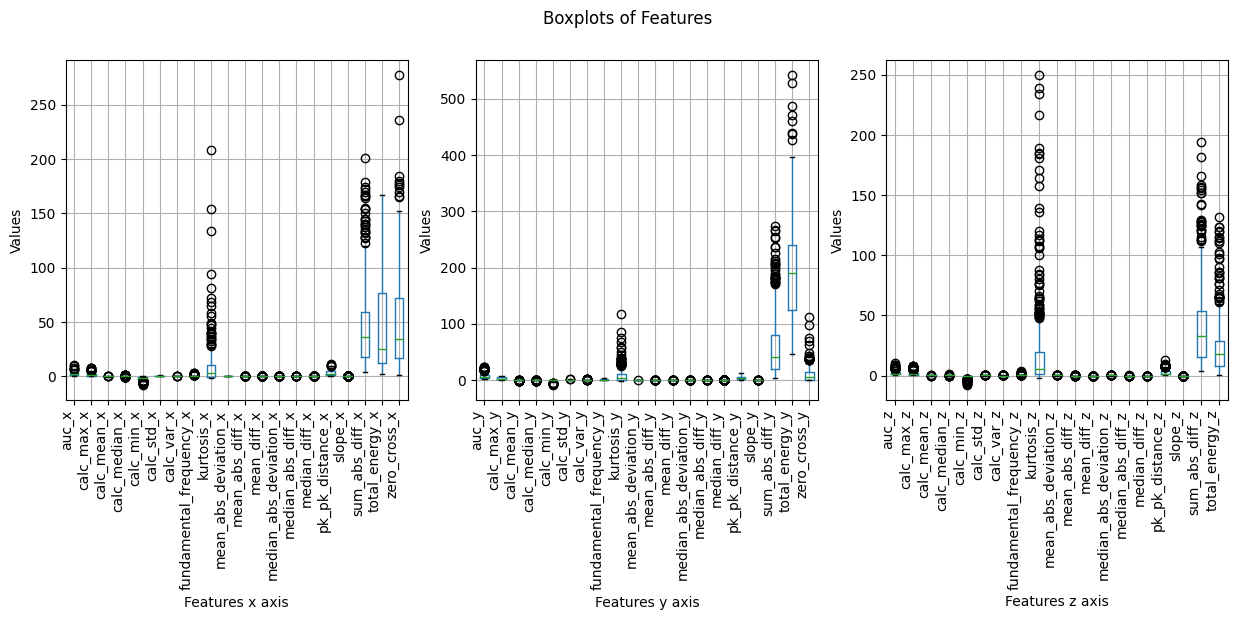

In [15]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Create a boxplot in each subplot
tsfeat.iloc[:, :len(method_list)].boxplot(ax=axes[0])
tsfeat.iloc[:, len(method_list):len(method_list)*2].boxplot(ax=axes[1])
tsfeat.iloc[:, len(method_list)*2:-1].boxplot(ax=axes[2])

# Set the labels and title of the plot
fig.suptitle('Boxplots of Features')
axes[0].set_xlabel('Features x axis')
axes[0].set_ylabel('Values')
axes[1].set_xlabel('Features y axis')
axes[1].set_ylabel('Values')
axes[2].set_xlabel('Features z axis')
axes[2].set_ylabel('Values')
fig.autofmt_xdate(rotation=90)

# Show the plot
plt.show()


## Interactive visualization of boxplots feature vs classes, divided by axis

In [16]:
from ipywidgets import interact, IntSlider, Layout

# Define a function to create a boxplot for a given feature
def create_boxplot(feature):
    # Group the data by class label
    grouped_data = tsfeat.copy()
    grouped_data['activity'] = list(labels.replace(range(1,len(activities)+1),activities))

    # Create a grid of subplots
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    # Create a boxplot in each subplot
    grouped_data.iloc[:, :].boxplot(ax=axes[0], column = tsfeat.columns[feature], by='activity')
    grouped_data.iloc[:, :].boxplot(ax=axes[1], column = tsfeat.columns[feature+len(method_list)], by='activity')
    grouped_data.iloc[:, :].boxplot(ax=axes[2], column = tsfeat.columns[feature+len(method_list)*2], by='activity')

    # Set the labels and title of the plot
    fig.suptitle('Boxplots of Features {}'.format(tsfeat.columns[feature][:-2]))
    fig.autofmt_xdate(rotation=90)

# Create a slider to change features
slider_layout = Layout(width='50%')
feature_slider = IntSlider(min=0, max=tsfeat.shape[1]/3 -1, step=1, value=0, layout=slider_layout, description='Select Feature:', style={'description_width': 'initial', 'handle_color': 'blue'})


# Create an interactive plot
interact(create_boxplot, feature=feature_slider)

interactive(children=(IntSlider(value=0, description='Select Feature:', layout=Layout(width='50%'), max=19, st…

<function __main__.create_boxplot(feature)>

# 4. Model making

## 4.1 Getting the dataset ready for the models
### 4.1.1 Feature selection via correlation


In [17]:
# Import the necessary modules for confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Import the necessary modules for cross validation and traing/test split
from sklearn.model_selection import train_test_split, cross_val_score

# Import the necessary modules for permutation importance
from sklearn.inspection import permutation_importance

# Import the necessary modules for standardization
from sklearn.preprocessing import StandardScaler

# Import the necessary modules for logistic regression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Import the necessary modules for random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay
from sklearn.tree import plot_tree

# Import the necessary modules for KNN
from sklearn.neighbors import KNeighborsClassifier

# Import the necessary modules for SVC
from sklearn.svm import SVC

# Import the necessary modules for Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Import the necessary modules for ensemble model
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier

# Import the necessary modules for TSNE and interactive plots
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact


In [18]:
# Compute the correlation matrix
corr_matrix = tsfeat.corr()

# Select the highly correlated features
highly_correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            if colname_i not in highly_correlated_features and colname_j not in highly_correlated_features:
                highly_correlated_features.add(colname_i)

# Remove the highly correlated features from the dataset
tsfeat_no_corr = tsfeat.drop(highly_correlated_features, axis=1)

# Print the remaining features
print('Remaining Features:', tsfeat_no_corr.columns)


Remaining Features: Index(['auc_x', 'calc_max_x', 'calc_mean_x', 'calc_min_x', 'calc_std_x',
       'fundamental_frequency_x', 'kurtosis_x', 'mean_abs_diff_x',
       'mean_diff_x', 'median_abs_deviation_x', 'median_diff_x',
       'zero_cross_x', 'calc_max_y', 'calc_mean_y', 'calc_min_y',
       'fundamental_frequency_y', 'kurtosis_y', 'mean_abs_deviation_y',
       'mean_diff_y', 'median_abs_deviation_y', 'median_abs_diff_y',
       'median_diff_y', 'zero_cross_y', 'auc_z', 'calc_max_z', 'calc_mean_z',
       'calc_min_z', 'fundamental_frequency_z', 'kurtosis_z',
       'mean_abs_deviation_z', 'mean_diff_z', 'median_diff_z', 'zero_cross_z'],
      dtype='object')


### 4.1.2 Dataset Split and Normalization

In [19]:
# Division in Train and Test set (70%-30%)
X_train, X_test, Y_train, Y_test = train_test_split(tsfeat_no_corr, np.array(
    list(labels)), test_size=0.3, random_state=1999, stratify=np.array(list(labels)))


In [20]:
X_train.head()


,auc_x,calc_max_x,calc_mean_x,calc_min_x,calc_std_x,fundamental_frequency_x,kurtosis_x,mean_abs_diff_x,mean_diff_x,median_abs_deviation_x,...,auc_z,calc_max_z,calc_mean_z,calc_min_z,fundamental_frequency_z,kurtosis_z,mean_abs_deviation_z,mean_diff_z,median_diff_z,zero_cross_z
0,2.039928,1.677143,0.177526,-0.686630,0.250421,1.933405,6.432821,0.030703,0.000028,0.105477,...,1.389332,0.708814,0.135577,-0.333327,0.107411,2.309042,0.092786,0.000011,0.000396,54.0
0,2.646142,1.259251,-0.404884,-2.868473,0.411569,0.183150,3.730228,0.026565,-0.000933,0.192132,...,3.658599,7.229624,0.669237,-0.205298,0.183150,112.461713,0.213248,0.000762,0.000320,2.0
0,2.544365,0.391241,-0.379322,-1.801554,0.481583,0.166667,-1.600170,0.013537,-0.000833,0.145416,...,1.837141,1.033324,0.305588,0.053271,0.166667,4.716915,0.074662,0.000079,0.000256,0.0
0,4.678169,4.881626,0.447452,-1.027193,0.577751,0.105820,6.425507,0.018621,0.000553,0.184874,...,1.587150,0.591762,0.144340,-2.031541,0.105820,26.579393,0.137978,0.000111,0.000121,96.0
0,0.840626,0.249569,-0.123931,-0.569175,0.235770,0.204082,-0.824695,0.007569,0.000796,0.067065,...,0.614842,0.517194,0.095868,-0.164085,0.204082,0.863265,0.112347,-0.000289,-0.000248,25.0


In [21]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


(327, 33)
(141, 33)
(327,)
(141,)


In [22]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### 4.1.3 Defining functions for plotting metrics

In [23]:
# Function to plot the future importances and the confusion matrix
def plot_importance_confusion(importances, X_train, y_predict, activities):
    # Plot the feature importances and confusion matrix side by side
    fig, axs = plt.subplots(ncols=2, figsize=(18, 10))

    # Plot the feature importances
    axs[0].bar(X_train.columns, importances)
    values_list = np.arange(0, len(X_train.columns))
    axs[0].xaxis.set_ticks(values_list)
    axs[0].set_xticklabels(X_train.columns, rotation=90)
    axs[0].set_title('Feature Importances')

    # Plot the confusion matrix
    cm = confusion_matrix(Y_test, y_predict, normalize='true')
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', ax=axs[1])
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('Actual')
    axs[1].set_title('Confusion Matrix')
    axs[1].set_xticklabels(activities, rotation=90)
    axs[1].set_yticklabels(activities, rotation=90)

    plt.show()


In [24]:
# Function to plot the future importances and the confusion matrix for top k features
def plot_importance_confusion_top_k(importances, X_train, y_predict, activities, top_k_features, top_k_indices, k):
    # Plot the feature importances and confusion matrix side by side
    fig, axs = plt.subplots(ncols=2, figsize=(18, 10))

    # Plot the feature importances
    axs[0].bar(top_k_features, importances[top_k_indices])
    values_list = np.arange(0, k)
    axs[0].xaxis.set_ticks(values_list)
    axs[0].set_xticklabels(top_k_features, rotation=90)
    axs[0].set_xlabel('Features')
    axs[0].set_ylabel('Importance')
    axs[0].set_title('Feature Importances')

    # Plot the confusion matrix
    cm = confusion_matrix(Y_test, y_predict, normalize='true')
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', ax=axs[1])
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('Actual')
    axs[1].set_title('Confusion Matrix')
    axs[1].set_xticklabels(activities, rotation=90)
    axs[1].set_yticklabels(activities, rotation=90)

    plt.show()


In [25]:
# Get the classification report and evaluate the model using cross-validation on the training set
def evaluate_model(model, X_train_scaled, y_predict, Y_train, Y_test, activities):
    accuracy = accuracy_score(Y_test, y_predict)*100
    print(classification_report(Y_test, y_predict, target_names=activities))
    print('Accuracy: ' + str(accuracy) + '%')

    scores = cross_val_score(model, X_train_scaled, Y_train, cv=5)
    print('Cross-validation scores:', scores)
    print('Mean cross-validation score:', scores.mean())


In [26]:
# Get the classification report and evaluate the model using cross-validation on the training set for top k features
def evaluate_model_top_k(model, X_train_scaled, y_predict, Y_train, Y_test, activities, top_k_indices):
    accuracy = accuracy_score(Y_test, y_predict)*100
    print(classification_report(Y_test, y_predict, target_names=activities))
    print('Accuracy: ' + str(accuracy) + '%')

    scores = cross_val_score(
        model, X_train_scaled[:, top_k_indices], Y_train, cv=5)
    print('Cross-validation scores:', scores)
    print('Mean cross-validation score:', scores.mean())


## 4.2 Model development

### 4.2.1 Logistic Regression

In [27]:
# Perform hyperparameter tuning using GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train_scaled, Y_train)

# Train the logistic regression classifier with the best hyperparameters
logistic_regression_classifier = grid_search.best_estimator_
logistic_regression_classifier.fit(X_train_scaled, Y_train)

# Predict test data
y_predict = logistic_regression_classifier.predict(X_test_scaled)

# Get the classification report and evaluate the model using cross-validation on the training set
evaluate_model(logistic_regression_classifier, X_train_scaled,
               y_predict, Y_train, Y_test, activities)

# Calculate the odds ratio and effect size
odds_ratio = np.exp(logistic_regression_classifier.coef_)
effect_size = odds_ratio / (odds_ratio + 1)

# Get the effect sizes
effect_sizes = logistic_regression_classifier.coef_[0]


c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

                  precision    recall  f1-score   support

         walking       0.87      0.95      0.91        21
         running       1.00      1.00      1.00        21
         jumping       0.95      0.95      0.95        20
    walking_down       0.75      0.75      0.75         4
      walking_up       1.00      0.50      0.67         4
 forward falling       0.80      0.80      0.80        10
sideways falling       1.00      0.90      0.95        10
backward falling       0.78      0.70      0.74        10
           lying       0.73      0.80      0.76        10
           other       0.88      0.90      0.89        31

        accuracy                           0.89       141
       macro avg       0.87      0.83      0.84       141
    weighted avg       0.89      0.89      0.88       141

Accuracy: 88.65248226950354%
Cross-validation scores: [0.92424242 0.84848485 0.84615385 0.87692308 0.84615385]
Mean cross-validation score: 0.8683916083916083


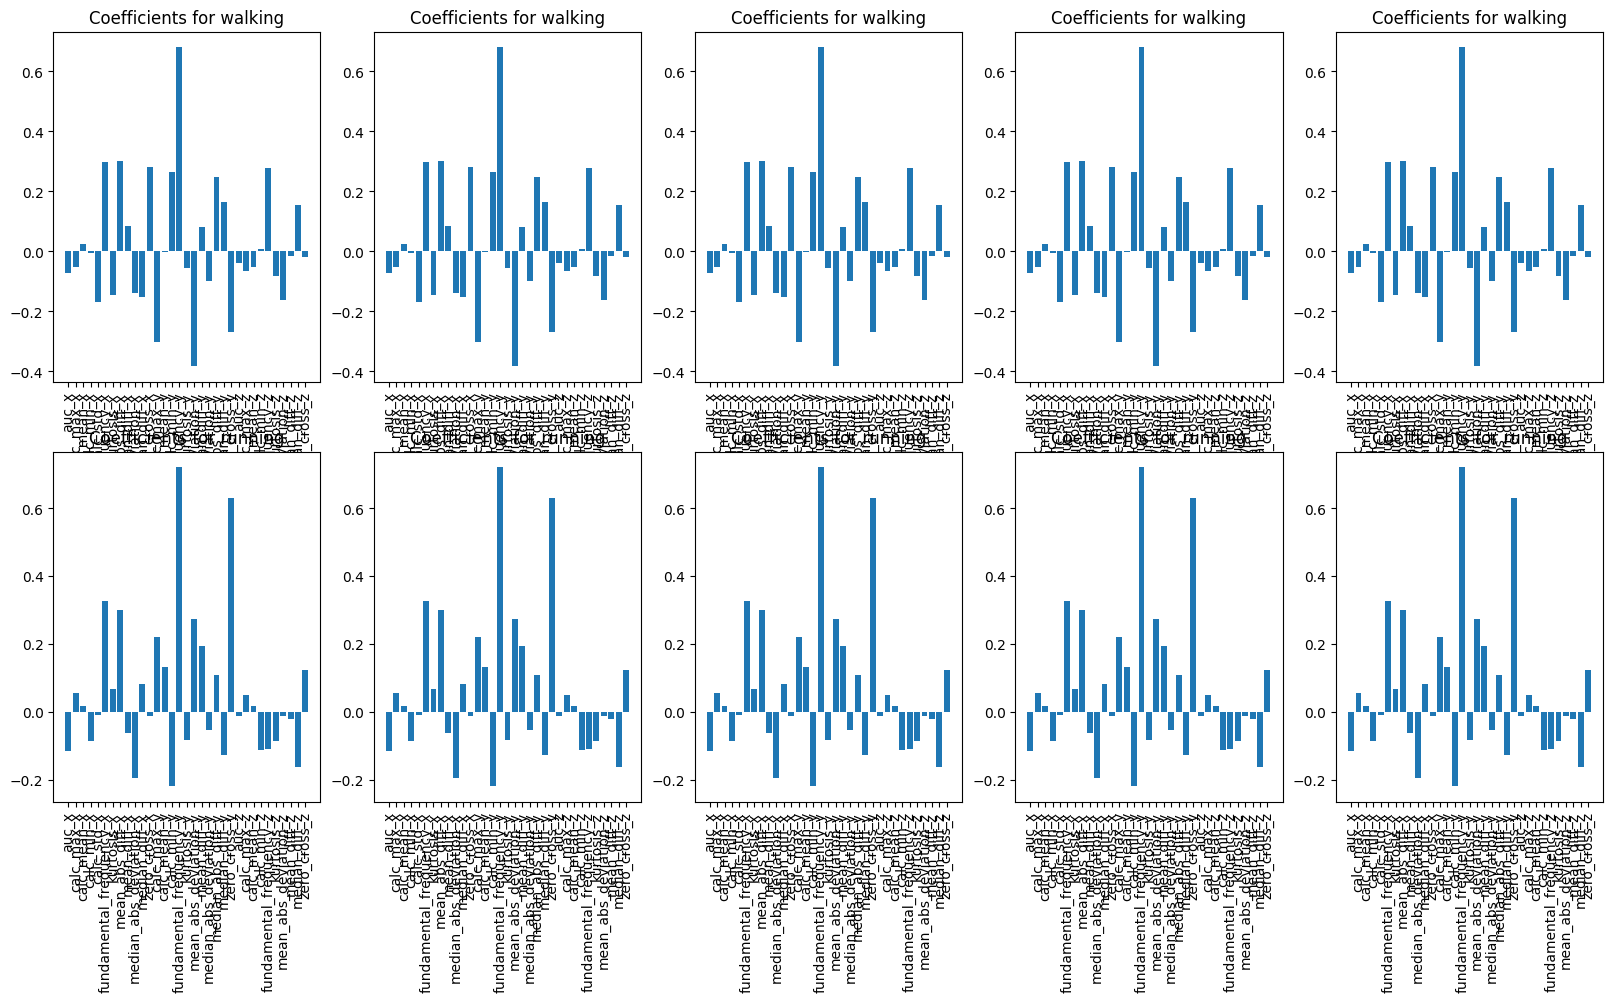

In [28]:
# Get the coefficients for each class
coefficients = logistic_regression_classifier.coef_

# Plot the coefficients for each class
nrows = 2
ncols = len(activities)//2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))

for i in np.arange(nrows):
    for j in range(ncols):
        axs[i,j].bar(range(len(coefficients[i])), coefficients[i])
        axs[i,j].set_xticks(range(len(effect_sizes)))
        axs[i,j].set_xticklabels(X_train.columns, rotation=90)
        axs[i,j].set_title('Coefficients for ' + activities[i])
plt.show()


In [29]:
# Use feature selection to select the most important features
feature_selector = SelectFromModel(
    logistic_regression_classifier, threshold=-np.inf, max_features=13)
feature_selector.fit(X_train_scaled, Y_train)

# Get the selected features
selected_features = X_train.columns[feature_selector.get_support()]
index_selected_features = feature_selector.get_support(indices=True)

# Train the logistic regression model with the selected features
X_train_selected = X_train_scaled[:, index_selected_features]
X_test_selected = X_test_scaled[:, index_selected_features]

logistic_regression_classifier.fit(X_train_selected, Y_train)

# Predict test data with the selected features
y_predict_selected = logistic_regression_classifier.predict(X_test_selected)

# Get the classification report and confusion matrix
accuracy_selected = accuracy_score(Y_test, y_predict_selected)*100
print(classification_report(Y_test, y_predict_selected, target_names=activities))
print('Accuracy with selected features: ' + str(accuracy_selected) + '%')
conf_matrix_selected = confusion_matrix(Y_test, y_predict_selected)


                  precision    recall  f1-score   support

         walking       0.90      0.90      0.90        21
         running       1.00      1.00      1.00        21
         jumping       0.90      0.95      0.93        20
    walking_down       0.00      0.00      0.00         4
      walking_up       0.40      0.50      0.44         4
 forward falling       0.62      0.50      0.56        10
sideways falling       0.90      0.90      0.90        10
backward falling       0.88      0.70      0.78        10
           lying       0.64      0.90      0.75        10
           other       0.91      0.94      0.92        31

        accuracy                           0.85       141
       macro avg       0.72      0.73      0.72       141
    weighted avg       0.84      0.85      0.84       141

Accuracy with selected features: 85.1063829787234%


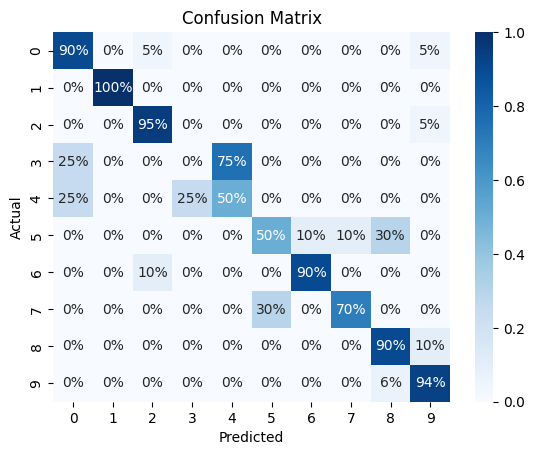

In [30]:
# Plot the confusion matrix
cm = confusion_matrix(Y_test, y_predict_selected, normalize='true')
sns.heatmap(cm, annot=True, fmt='.0%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


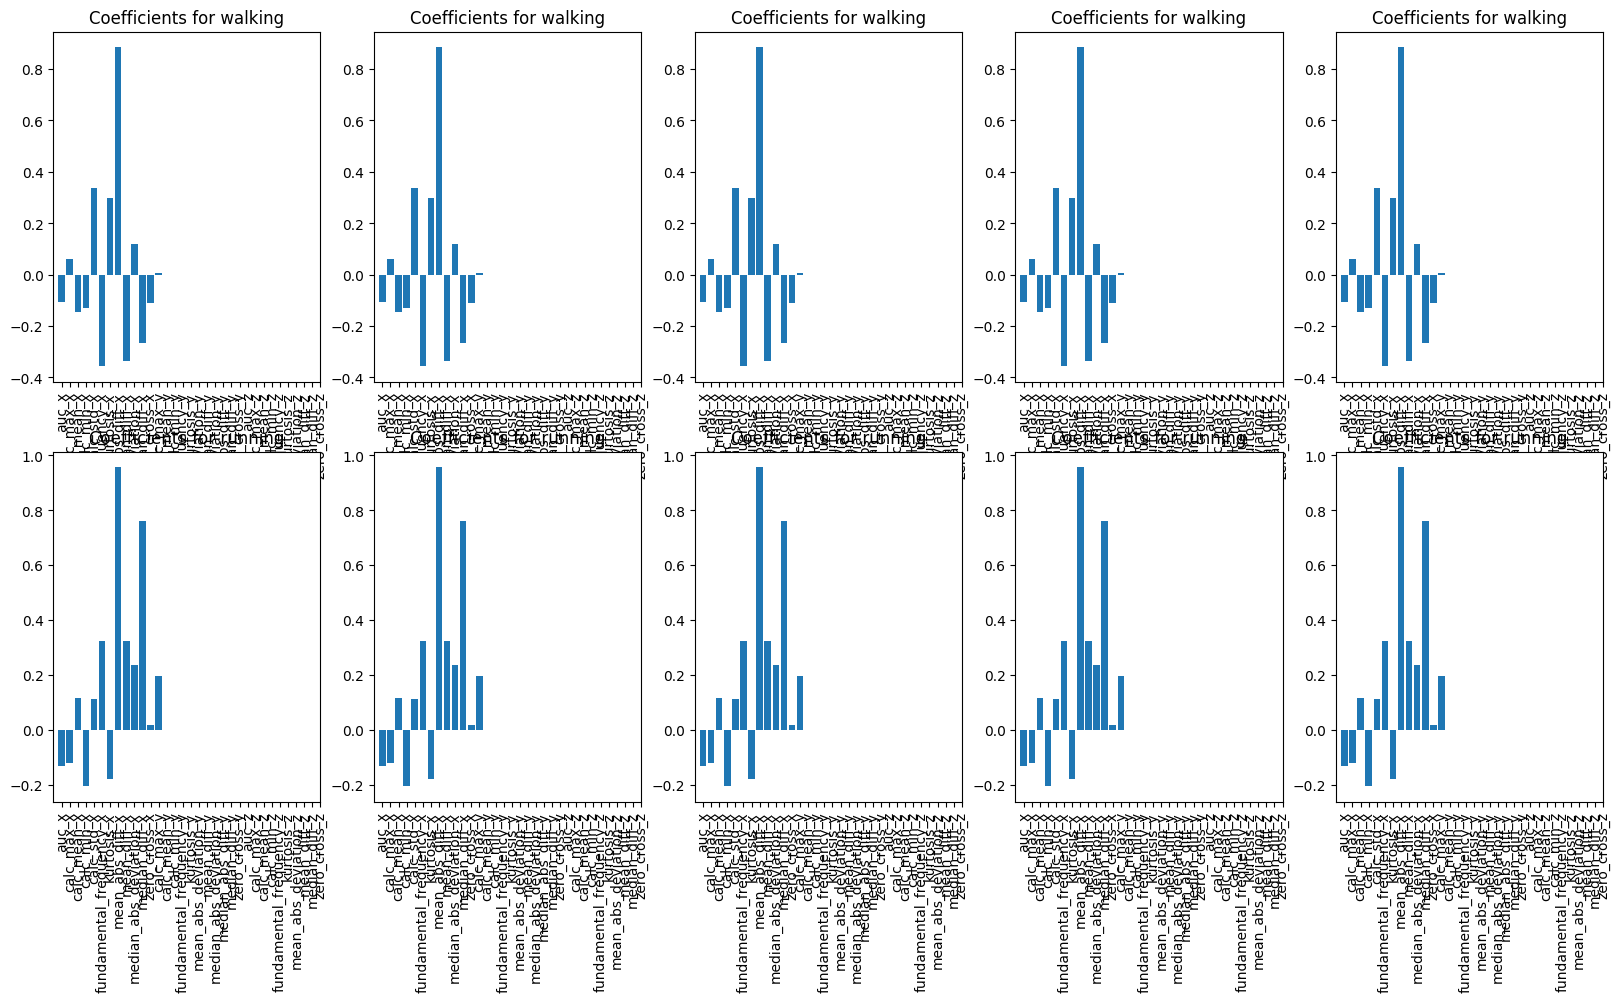

In [31]:
# Get the coefficients for each class
coefficients = logistic_regression_classifier.coef_

# Plot the coefficients for each class
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))
for i in np.arange(nrows):
    for j in range(ncols):
        axs[i,j].bar(range(len(coefficients[i])), coefficients[i])
        axs[i,j].set_xticks(range(len(effect_sizes)))
        axs[i,j].set_xticklabels(X_train.columns, rotation=90)
        axs[i,j].set_title('Coefficients for ' + activities[i])
plt.show()

logistic_regression_classifier = logistic_regression_classifier


#### ROC

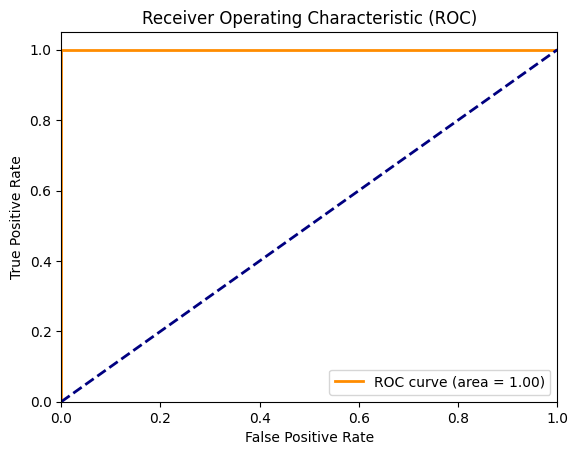

In [32]:
# Compute the predicted probabilities for the positive class
y_prob = logistic_regression_classifier.predict_proba(X_test_selected)[:, 1]

# Compute the false positive rate, true positive rate, and threshold
fpr, tpr, threshold = roc_curve(Y_test, y_prob, pos_label=2)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### 4.2.2 Random Forest

#### GridSearch

In [33]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Train the random forest classifier using cross-validation and hyperparameter tuning
random_forest_classifier = RandomForestClassifier()
grid_search = GridSearchCV(random_forest_classifier, param_grid, cv=5)
grid_search.fit(X_train_scaled, Y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the random forest classifier using the best hyperparameters
random_forest_classifier = RandomForestClassifier(**best_params)
random_forest_classifier.fit(X_train_scaled, Y_train)

# Get the feature importances
importances = random_forest_classifier.feature_importances_

# Predict test data
y_predict = random_forest_classifier.predict(X_test_scaled)

# Get the classification report and evaluate the model using cross-validation on the training set
evaluate_model(random_forest_classifier, X_train_scaled,
               y_predict, Y_train, Y_test, activities)


                  precision    recall  f1-score   support

         walking       0.90      0.90      0.90        21
         running       0.95      1.00      0.98        21
         jumping       1.00      0.95      0.97        20
    walking_down       1.00      0.75      0.86         4
      walking_up       1.00      0.75      0.86         4
 forward falling       0.89      0.80      0.84        10
sideways falling       1.00      1.00      1.00        10
backward falling       0.80      0.80      0.80        10
           lying       0.82      0.90      0.86        10
           other       0.91      0.97      0.94        31

        accuracy                           0.92       141
       macro avg       0.93      0.88      0.90       141
    weighted avg       0.92      0.92      0.92       141

Accuracy: 92.19858156028369%
Cross-validation scores: [0.90909091 0.87878788 0.93846154 0.89230769 0.87692308]
Mean cross-validation score: 0.8991142191142192


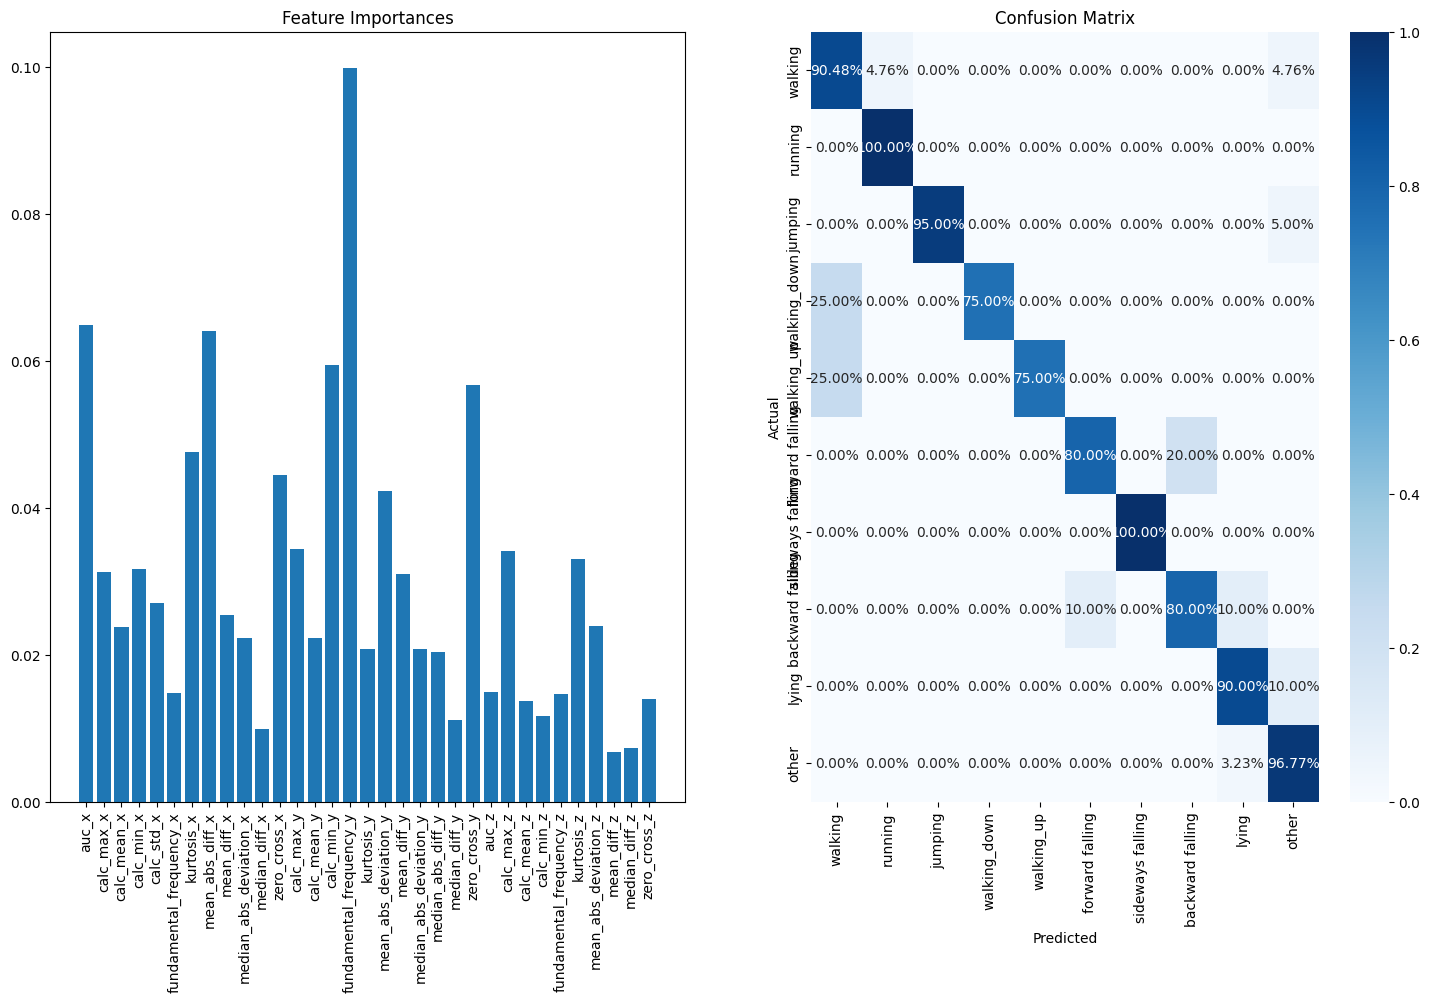

In [34]:
# Plot the feature importances and confusion matrix side by side
plot_importance_confusion(importances, X_train, y_predict, activities)


#### Feature importance selection

In [35]:
# Select the top k features
k = 4
top_k_indices = importances.argsort()[::-1][:k]
top_k_features = X_train.columns[top_k_indices]

# Train the random forest classifier using the top k features
random_forest_classifier = RandomForestClassifier(**best_params)
random_forest_classifier.fit(X_train_scaled[:, top_k_indices], Y_train)

# Predict test data
y_predict = random_forest_classifier.predict(X_test_scaled[:, top_k_indices])

# Get the classification report and evaluate the model using cross-validation on the training set with top k features
evaluate_model_top_k(random_forest_classifier, X_train_scaled,
                     y_predict, Y_train, Y_test, activities, top_k_indices)


c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

                  precision    recall  f1-score   support

         walking       0.90      0.90      0.90        21
         running       0.95      1.00      0.98        21
         jumping       0.95      0.95      0.95        20
    walking_down       0.00      0.00      0.00         4
      walking_up       0.67      1.00      0.80         4
 forward falling       0.67      0.80      0.73        10
sideways falling       0.90      0.90      0.90        10
backward falling       1.00      0.60      0.75        10
           lying       0.60      0.90      0.72        10
           other       0.86      0.81      0.83        31

        accuracy                           0.85       141
       macro avg       0.75      0.79      0.76       141
    weighted avg       0.84      0.85      0.84       141

Accuracy: 85.1063829787234%
Cross-validation scores: [0.86363636 0.74242424 0.83076923 0.84615385 0.81538462]
Mean cross-validation score: 0.8196736596736598


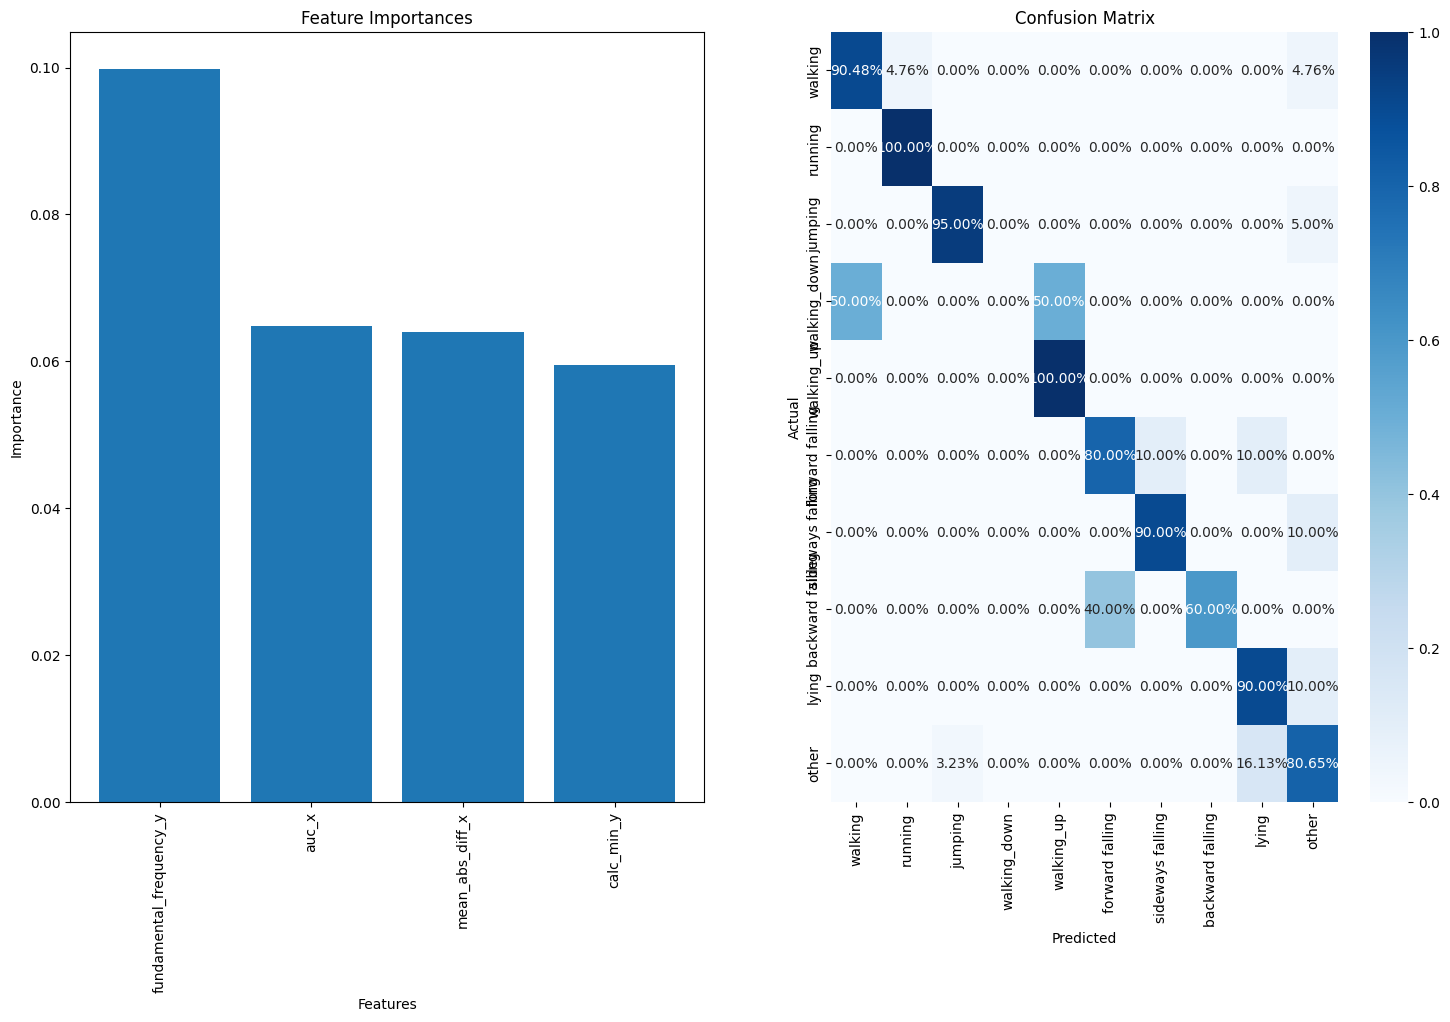

In [36]:
# Plot the feature importances and confusion matrix with top k features side by side
plot_importance_confusion_top_k(
    importances, X_train, y_predict, activities, top_k_features, top_k_indices, k)


#### Partial Dependence Plots

Text(0, 0.5, 'Partial Dependence')

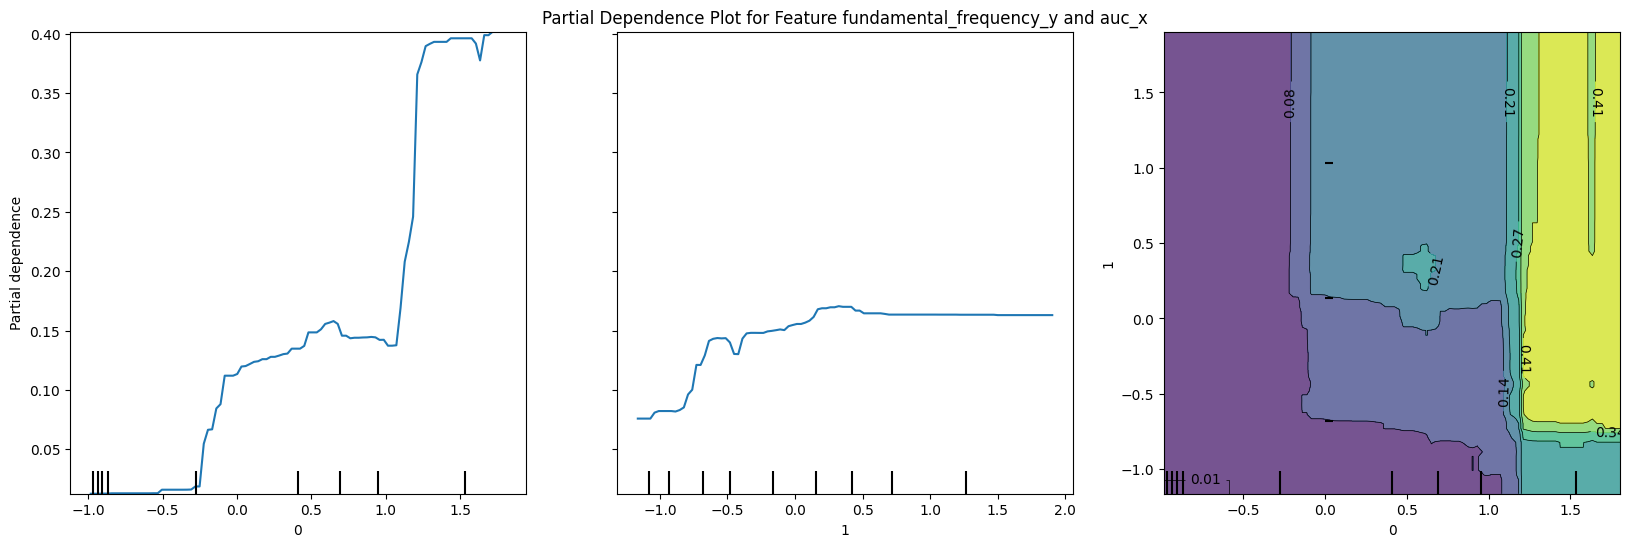

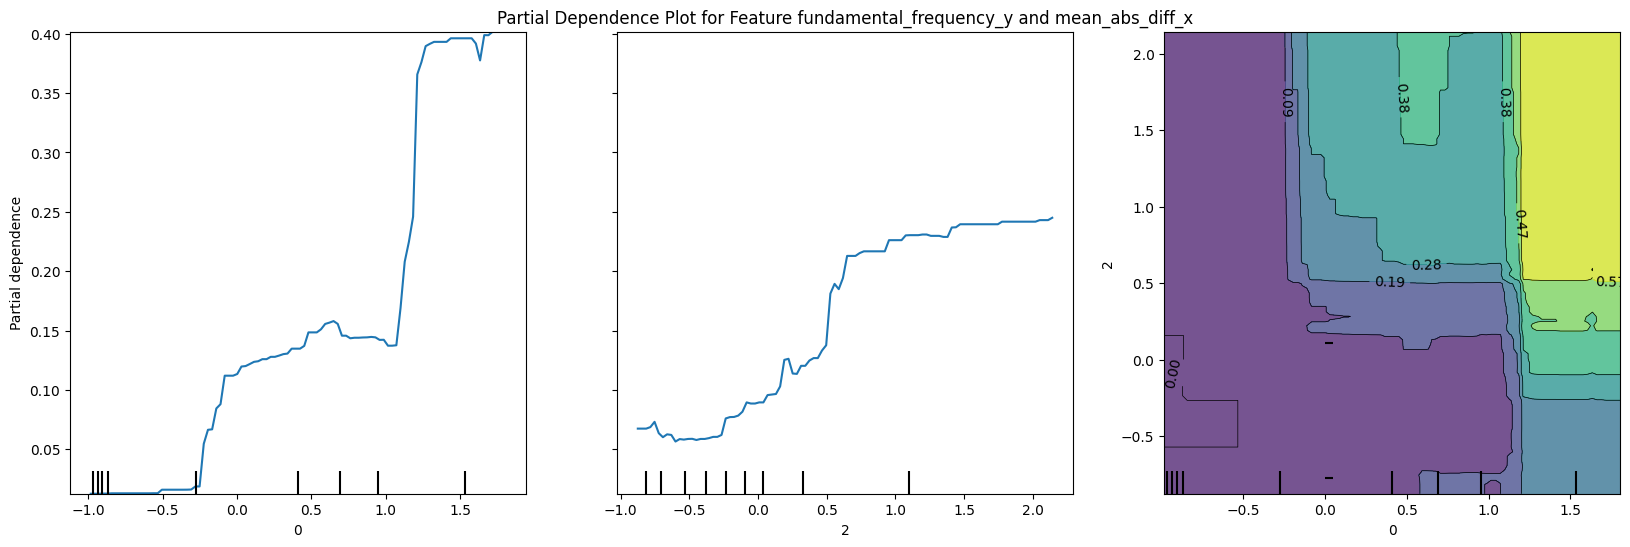

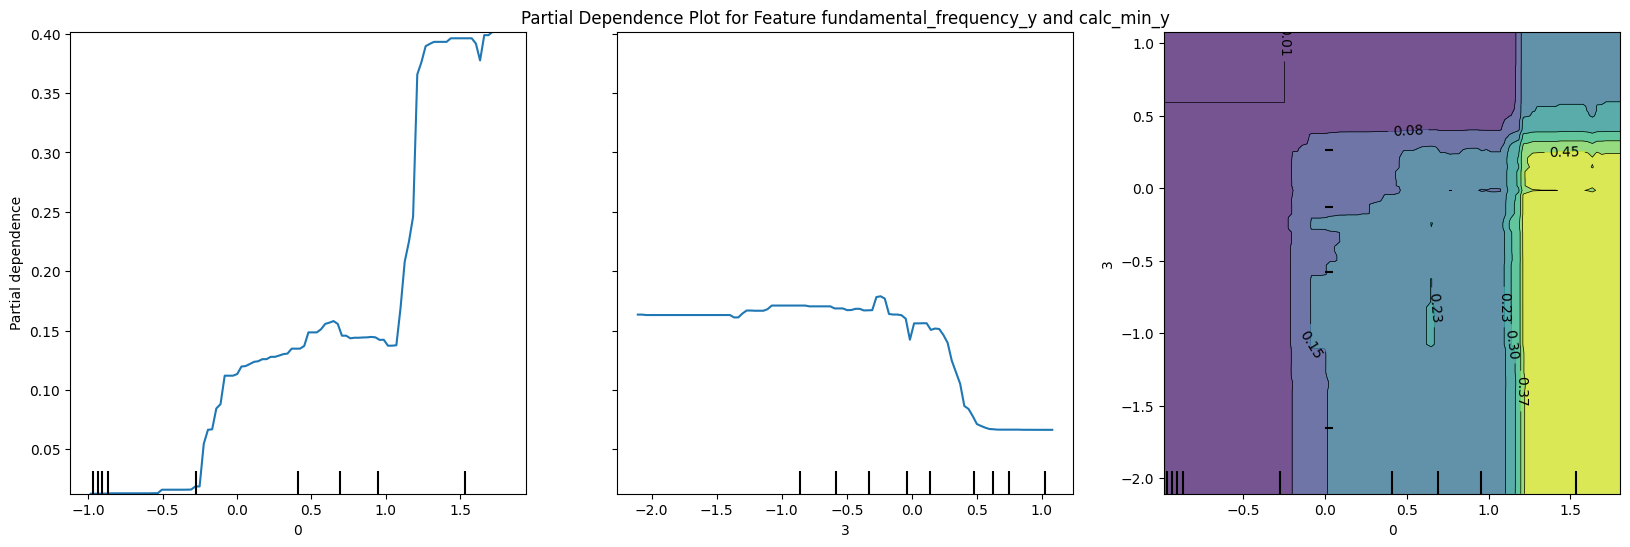

In [37]:
# Create the partial dependence plot for the top feature
fig, ax = plt.subplots(figsize=(20, 6))
PartialDependenceDisplay.from_estimator(random_forest_classifier, X_train_scaled[:, top_k_indices], [0, 1, (0,1)], ax=ax, target=2)
ax.set_title('Partial Dependence Plot for Feature {} and {}'.format(top_k_features[0], top_k_features[1]))
ax.set_ylabel('Partial Dependence')

# Create the partial dependence plot for the top feature
fig, ax = plt.subplots(figsize=(20, 6))
PartialDependenceDisplay.from_estimator(random_forest_classifier, X_train_scaled[:, top_k_indices], [0, 2, (0,2)], ax=ax, target=2)
ax.set_title('Partial Dependence Plot for Feature {} and {}'.format(top_k_features[0], top_k_features[2]))
ax.set_ylabel('Partial Dependence')

# Create the partial dependence plot for the top feature
fig, ax = plt.subplots(figsize=(20, 6))
PartialDependenceDisplay.from_estimator(random_forest_classifier, X_train_scaled[:, top_k_indices], [0, 3, (0,3)], ax=ax, target=2)
ax.set_title('Partial Dependence Plot for Feature {} and {}'.format(top_k_features[0], top_k_features[3]))
ax.set_ylabel('Partial Dependence')

Text(0, 0.5, 'Partial Dependence')

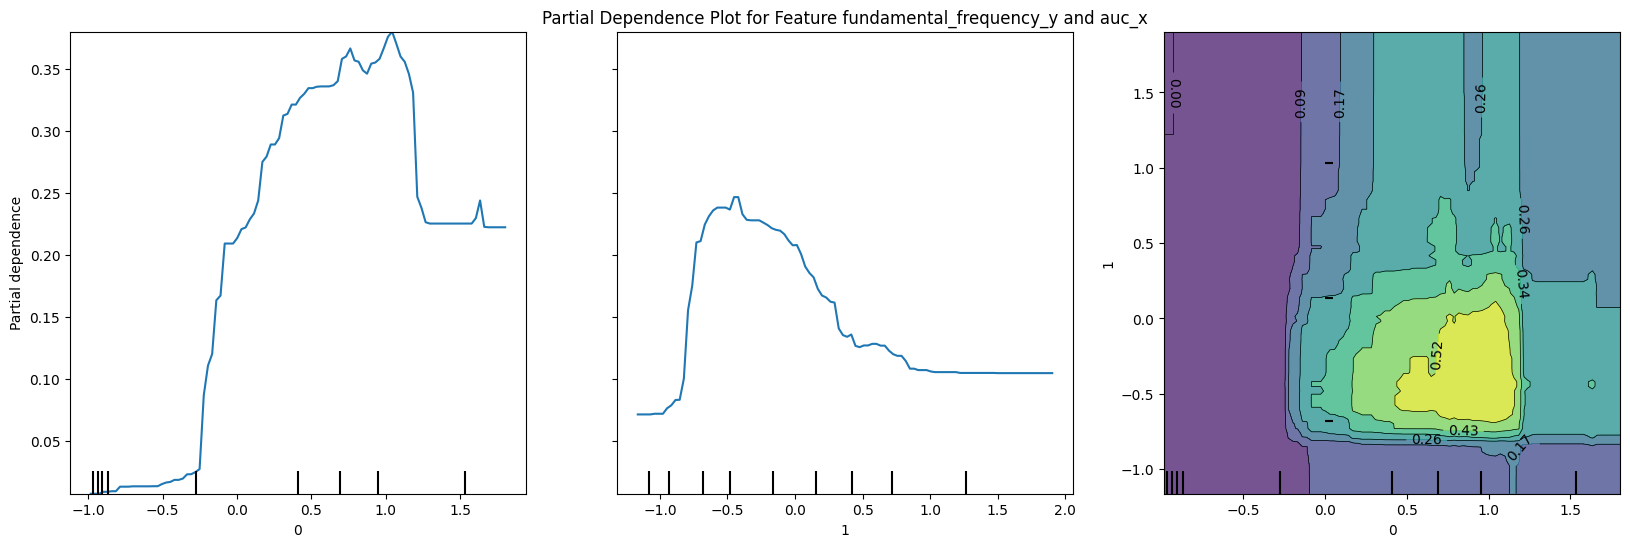

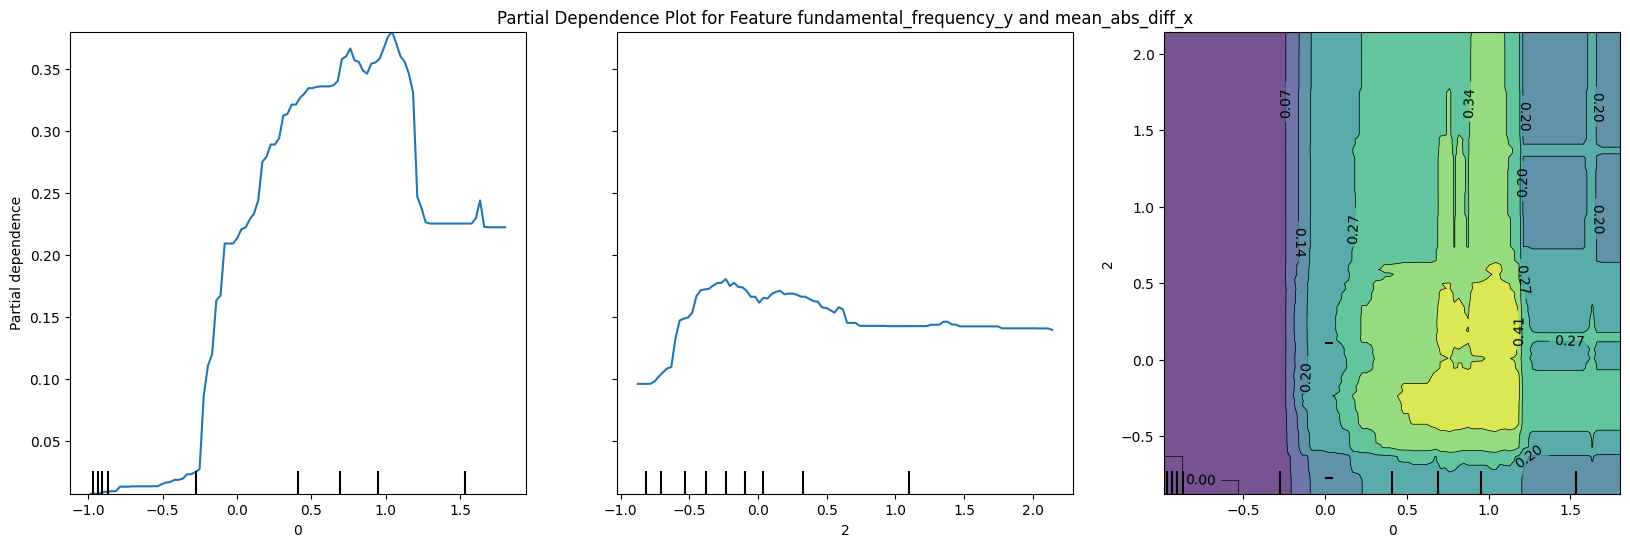

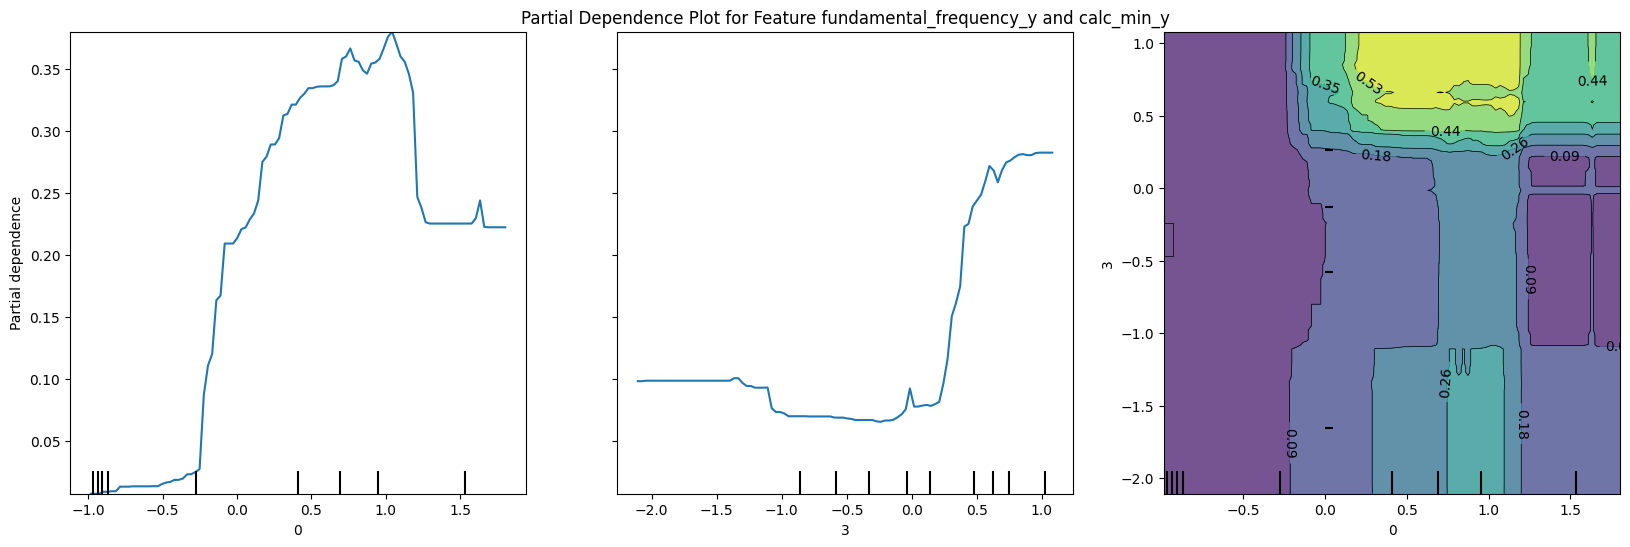

In [38]:
# Create the partial dependence plot for the top feature
fig, ax = plt.subplots(figsize=(20, 6))
PartialDependenceDisplay.from_estimator(random_forest_classifier, X_train_scaled[:, top_k_indices], [0, 1, (0,1)], ax=ax, target=1)
ax.set_title('Partial Dependence Plot for Feature {} and {}'.format(top_k_features[0], top_k_features[1]))
ax.set_ylabel('Partial Dependence')

# Create the partial dependence plot for the top feature
fig, ax = plt.subplots(figsize=(20, 6))
PartialDependenceDisplay.from_estimator(random_forest_classifier, X_train_scaled[:, top_k_indices], [0, 2, (0,2)], ax=ax, target=1)
ax.set_title('Partial Dependence Plot for Feature {} and {}'.format(top_k_features[0], top_k_features[2]))
ax.set_ylabel('Partial Dependence')

# Create the partial dependence plot for the top feature
fig, ax = plt.subplots(figsize=(20, 6))
PartialDependenceDisplay.from_estimator(random_forest_classifier, X_train_scaled[:, top_k_indices], [0, 3, (0,3)], ax=ax, target=1)
ax.set_title('Partial Dependence Plot for Feature {} and {}'.format(top_k_features[0], top_k_features[3]))
ax.set_ylabel('Partial Dependence')

#### Tree visualization

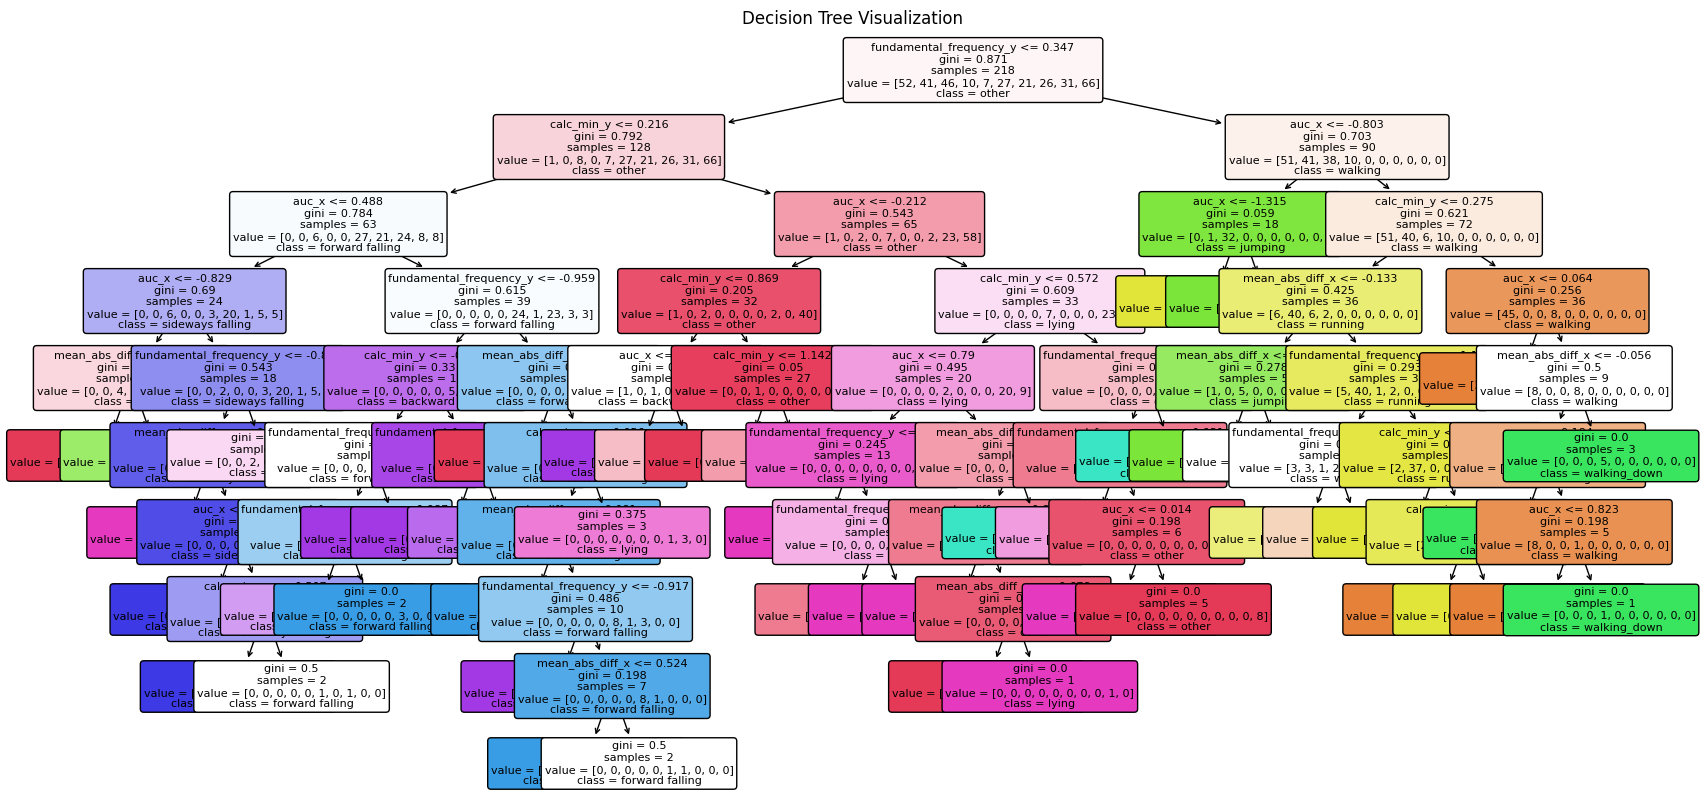

In [39]:
# Create the tree visualization for the first tree in the forest
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(random_forest_classifier.estimators_[3], ax=ax, feature_names=top_k_features, class_names=activities, filled=True, rounded=True, fontsize=8)
ax.set_title('Decision Tree Visualization')
plt.show()

#### ROC

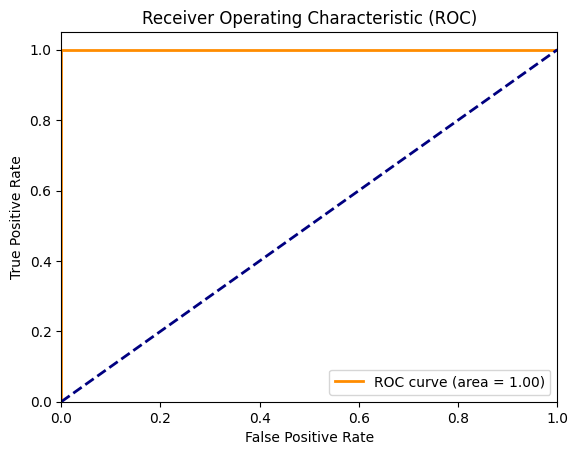

In [40]:
# Compute the predicted probabilities for the positive class
y_prob = random_forest_classifier.predict_proba(X_test_scaled[:,top_k_indices])[:, 1]

# Compute the false positive rate, true positive rate, and threshold
fpr, tpr, threshold = roc_curve(Y_test, y_prob, pos_label=2)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

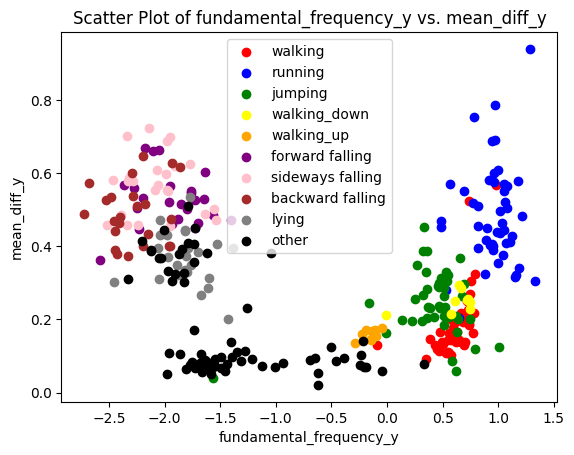

In [41]:
# Define the x and y variables
x = np.log(X_train['fundamental_frequency_y'])
y = X_train['mean_abs_deviation_y']

# Define the colors for each label
named_labels = pd.Series(Y_train).replace(
    {1: 'walking', 2: 'running', 3: 'jumping', 4: 'walking_down', 5: 'walking_up', 6: 'forward falling', 7: 'sideways falling', 8: 'backward falling', 9: 'lying', 10: 'other'})
colors = {'walking': 'red',  'running': 'blue', 'jumping': 'green', 'walking_down': 'yellow', 'walking_up': 'orange',
          'forward falling': 'purple', 'sideways falling': 'pink', 'backward falling': 'brown', 'lying': 'gray', 'other': 'black'}

['walking', 'running', 'jumping', 'walking_down', 'walking_up',
    'forward falling', 'sideways falling', 'backward falling', 'lying', 'other']


# Create the scatter plot
fig, ax = plt.subplots()
for label in colors:
    mask = named_labels == label
    ax.scatter(x[list(mask)], y[list(mask)], c=colors[label], label=label)

# Set the axis labels and title
ax.set_xlabel('fundamental_frequency_y')
ax.set_ylabel('mean_diff_y')
ax.set_title('Scatter Plot of fundamental_frequency_y vs. mean_diff_y')

# Add the legend
ax.legend()

# Show the plot
plt.show()


### 4.2.3 KNN

In [42]:
# Train the KNN
knn_classifier = KNeighborsClassifier()

# Fit the KNN classifier
knn_classifier.fit(X_train_scaled, Y_train)

# Get the feature importances using permutation importance

# Permutation importance measures the importance of a feature by randomly permuting its values
# and observing the impact on the model's performance. If permuting a feature greatly reduces the
# model's performance, it suggests that the feature is important.

result = permutation_importance(
    knn_classifier, X_test_scaled, Y_test, n_repeats=10, random_state=42)
importances = result.importances_mean

# Predict test data
y_predict = knn_classifier.predict(X_test_scaled)

# Get the classification report and evaluate the model using cross-validation on the training set
evaluate_model(knn_classifier, X_train_scaled,
               y_predict, Y_train, Y_test, activities)


                  precision    recall  f1-score   support

         walking       1.00      0.95      0.98        21
         running       1.00      1.00      1.00        21
         jumping       0.95      0.95      0.95        20
    walking_down       1.00      1.00      1.00         4
      walking_up       1.00      1.00      1.00         4
 forward falling       1.00      0.80      0.89        10
sideways falling       1.00      1.00      1.00        10
backward falling       0.78      0.70      0.74        10
           lying       0.71      1.00      0.83        10
           other       0.94      0.94      0.94        31

        accuracy                           0.94       141
       macro avg       0.94      0.93      0.93       141
    weighted avg       0.94      0.94      0.94       141

Accuracy: 93.61702127659575%
Cross-validation scores: [0.89393939 0.81818182 0.89230769 0.87692308 0.83076923]
Mean cross-validation score: 0.8624242424242425


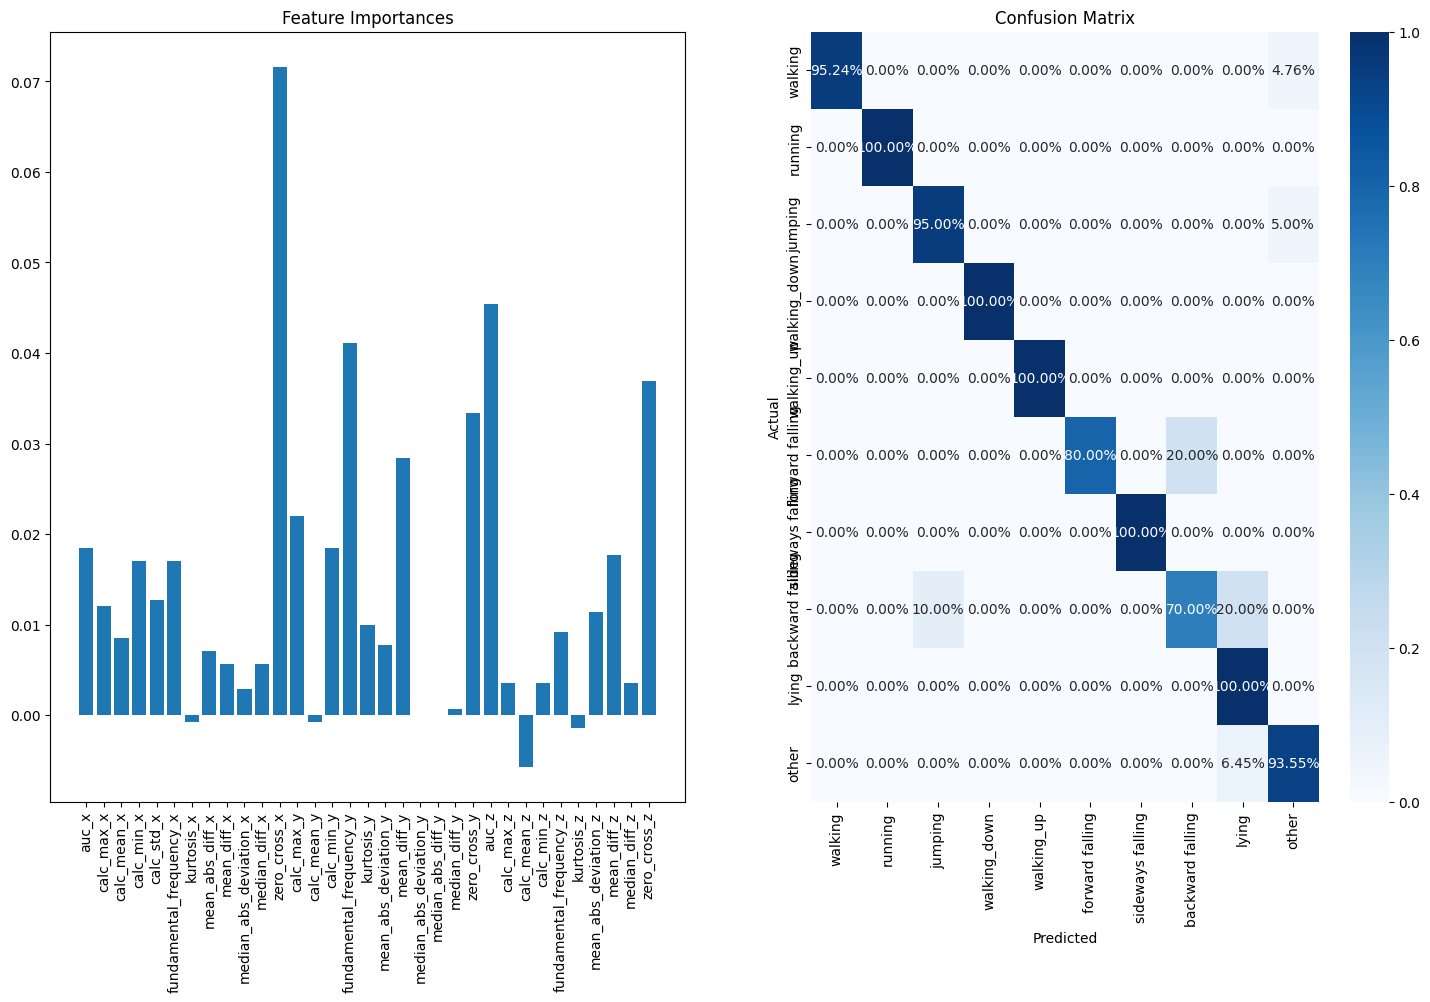

In [43]:
# Plot the feature importances and confusion matrix side by side
plot_importance_confusion(importances, X_train, y_predict, activities)


#### Feature importance selection

In [44]:
# Select the top k features
k = 10
top_k_indices = importances.argsort()[::-1][:k]
top_k_features = X_train.columns[top_k_indices]

# Train the KNN classifier using the top k features
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train_scaled[:, top_k_indices], Y_train)

# Predict test data
y_predict = knn_classifier.predict(X_test_scaled[:, top_k_indices])

# Get the classification report and evaluate the model using cross-validation on the training set with top k features
evaluate_model_top_k(knn_classifier, X_train_scaled, y_predict,
                     Y_train, Y_test, activities, top_k_indices)


                  precision    recall  f1-score   support

         walking       1.00      1.00      1.00        21
         running       0.88      1.00      0.93        21
         jumping       1.00      0.85      0.92        20
    walking_down       0.75      0.75      0.75         4
      walking_up       0.75      0.75      0.75         4
 forward falling       0.78      0.70      0.74        10
sideways falling       1.00      0.90      0.95        10
backward falling       0.86      0.60      0.71        10
           lying       0.62      1.00      0.77        10
           other       0.97      0.94      0.95        31

        accuracy                           0.89       141
       macro avg       0.86      0.85      0.85       141
    weighted avg       0.91      0.89      0.89       141

Accuracy: 89.36170212765957%
Cross-validation scores: [0.86363636 0.8030303  0.84615385 0.84615385 0.87692308]
Mean cross-validation score: 0.8471794871794872


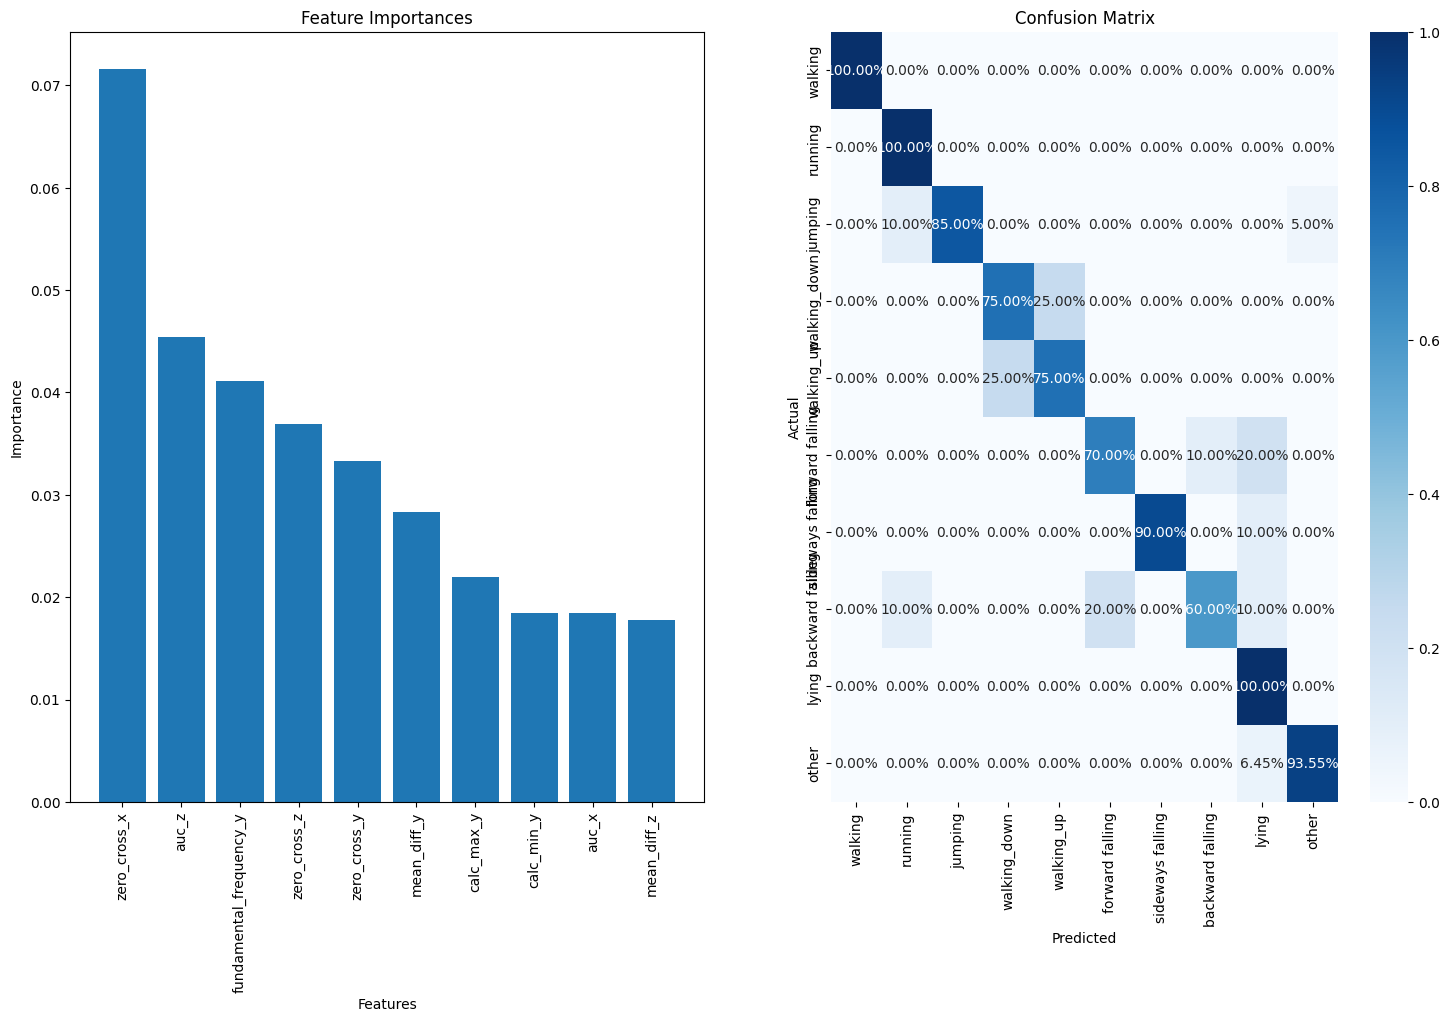

In [45]:
# Plot the feature importances and confusion matrix with top k features side by side
plot_importance_confusion_top_k(
    importances, X_train, y_predict, activities, top_k_features, top_k_indices, k)


### 4.2.4 SVM

In [46]:
# Define the parameter grid
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10],
              'kernel': ['linear', 'rbf', 'poly', 'gaussian']}

# Train the SVC using GridSearchCV to tune the hyperparameters
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train_scaled, Y_train)

# Get the best hyperparameters and kernel
best_params = grid_search.best_params_
best_kernel = best_params['kernel']
best_C = best_params['C']
best_gamma = best_params['gamma']

# Train the SVC with the best hyperparameters and kernel
svm_classifier = SVC(kernel=best_kernel, C=best_C, gamma=best_gamma)
svm_classifier.fit(X_train_scaled, Y_train)

# Get the feature importances using permutation importance

# Permutation importance measures the importance of a feature by randomly permuting its values
# and observing the impact on the model's performance. If permuting a feature greatly reduces the
# model's performance, it suggests that the feature is important.

result = permutation_importance(
    svm_classifier, X_test_scaled, Y_test, n_repeats=10, random_state=42)
importances = result.importances_mean

# Predict test data
y_predict = svm_classifier.predict(X_test_scaled)

# Get the classification report and evaluate the model using cross-validation on the training set
evaluate_model(svm_classifier, X_train_scaled,
               y_predict, Y_train, Y_test, activities)


c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py", line 251, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "c:\Users\andre\AppData\Local\Programs\Python\Python39\l

                  precision    recall  f1-score   support

         walking       1.00      1.00      1.00        21
         running       1.00      1.00      1.00        21
         jumping       1.00      0.95      0.97        20
    walking_down       1.00      1.00      1.00         4
      walking_up       1.00      1.00      1.00         4
 forward falling       0.70      0.70      0.70        10
sideways falling       1.00      1.00      1.00        10
backward falling       0.78      0.70      0.74        10
           lying       0.71      1.00      0.83        10
           other       0.97      0.90      0.93        31

        accuracy                           0.93       141
       macro avg       0.92      0.93      0.92       141
    weighted avg       0.94      0.93      0.93       141

Accuracy: 92.90780141843972%
Cross-validation scores: [0.93939394 0.90909091 0.89230769 0.93846154 0.86153846]
Mean cross-validation score: 0.9081585081585082


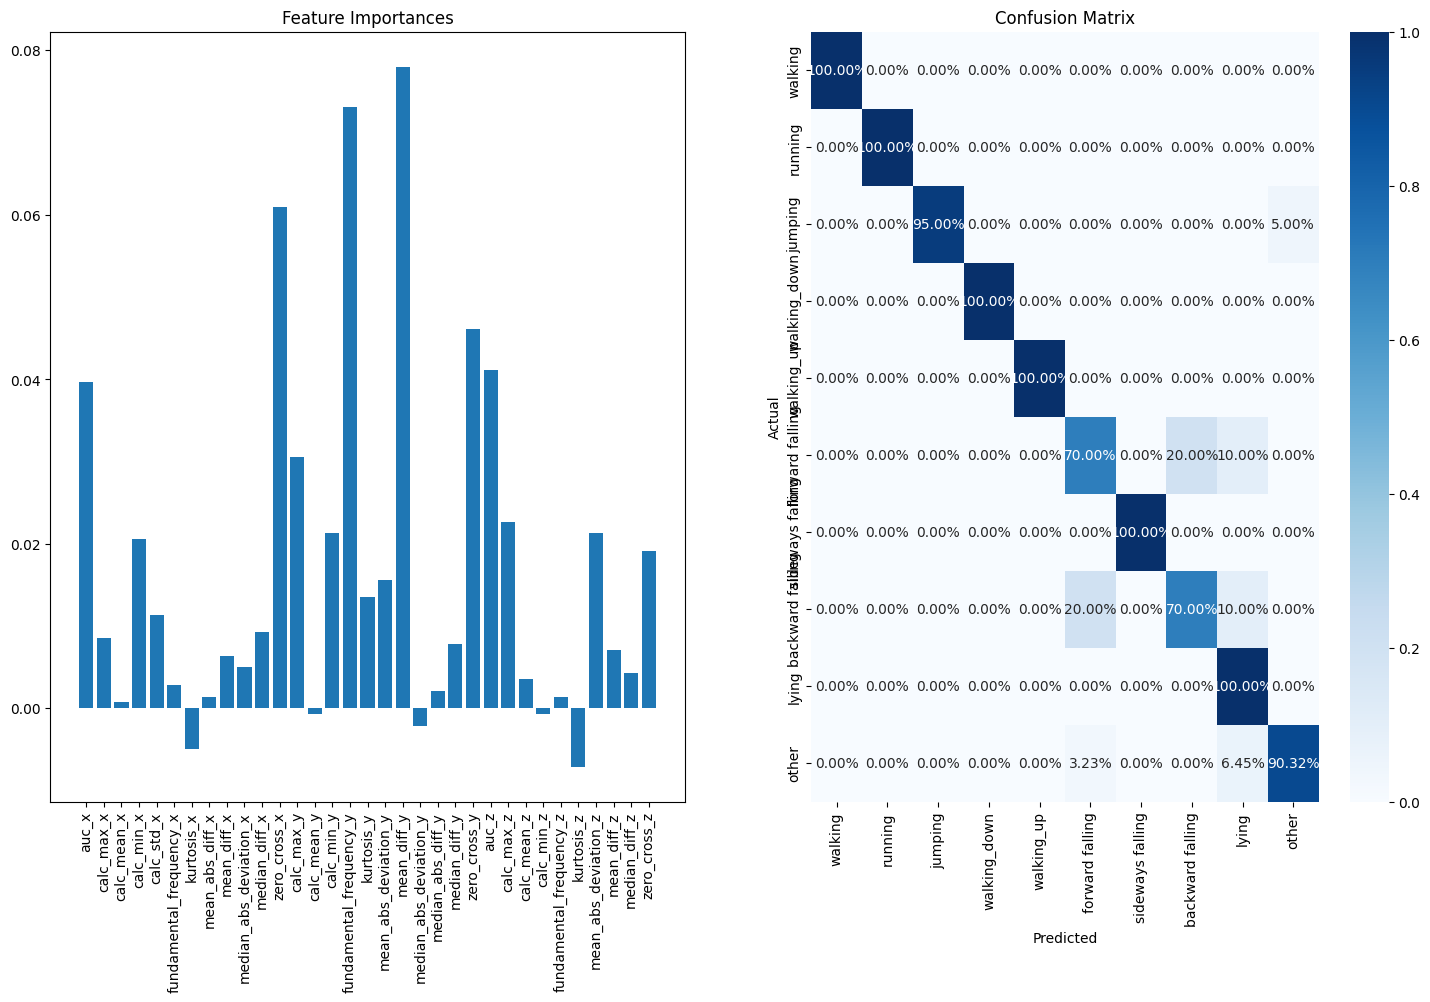

In [47]:
# Plot the feature importances and confusion matrix side by side
plot_importance_confusion(importances, X_train, y_predict, activities)


#### Feature importance selection

In [48]:
# Select the top k features
k = 9
top_k_indices = importances.argsort()[::-1][:k]
top_k_features = X_train.columns[top_k_indices]

# Train the SVC classifier using the top k features
best_kernel = best_params['kernel']
best_C = best_params['C']
best_gamma = best_params['gamma']

# Train the SVC with the best hyperparameters and kernel
svm_classifier = SVC(kernel=best_kernel, C=best_C, gamma=best_gamma)
svm_classifier.fit(X_train_scaled[:, top_k_indices], Y_train)

# Predict test data
y_predict = svm_classifier.predict(X_test_scaled[:, top_k_indices])

# Get the classification report and evaluate the model using cross-validation on the training set with top k features
evaluate_model_top_k(svm_classifier, X_train_scaled, y_predict,
                     Y_train, Y_test, activities, top_k_indices)


                  precision    recall  f1-score   support

         walking       0.91      1.00      0.95        21
         running       1.00      1.00      1.00        21
         jumping       1.00      0.95      0.97        20
    walking_down       0.75      0.75      0.75         4
      walking_up       1.00      0.50      0.67         4
 forward falling       0.54      0.70      0.61        10
sideways falling       1.00      1.00      1.00        10
backward falling       1.00      0.40      0.57        10
           lying       0.62      1.00      0.77        10
           other       0.97      0.90      0.93        31

        accuracy                           0.89       141
       macro avg       0.88      0.82      0.82       141
    weighted avg       0.91      0.89      0.88       141

Accuracy: 88.65248226950354%
Cross-validation scores: [0.84848485 0.87878788 0.89230769 0.89230769 0.83076923]
Mean cross-validation score: 0.8685314685314685


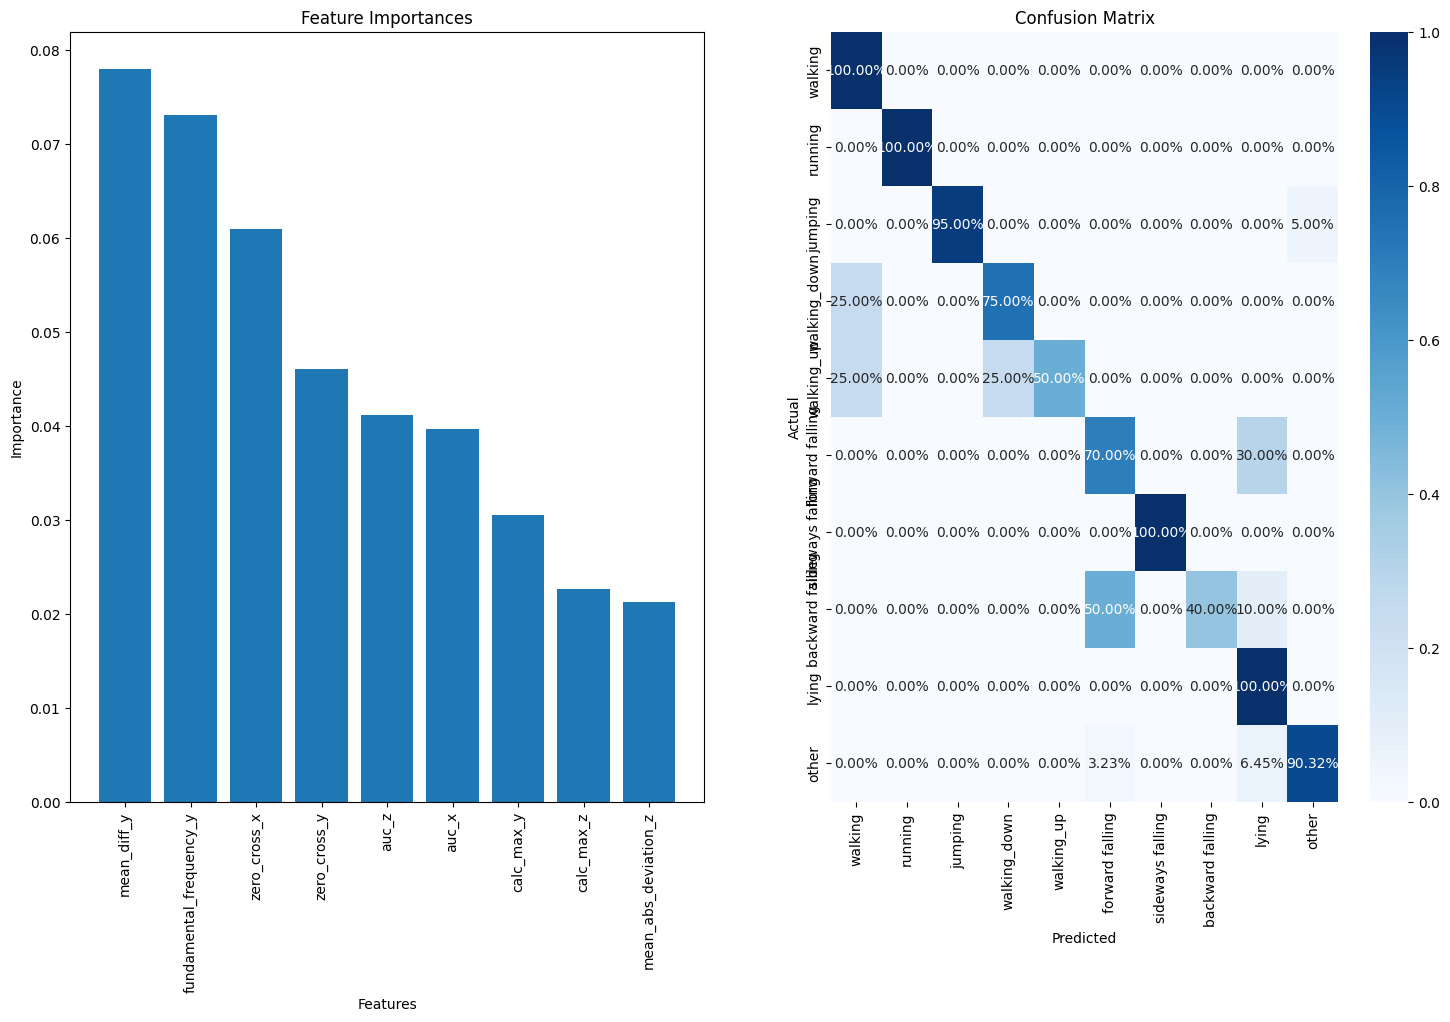

In [49]:
# Plot the feature importances and confusion matrix with top k features side by side
plot_importance_confusion_top_k(
    importances, X_train, y_predict, activities, top_k_features, top_k_indices, k)


### 4.2.5 Gaussian Naive Bayes Classifier

In [50]:
# Train the Naive Bayes classifier
bayes_classifier = GaussianNB()

# Train The Classifier
bayes_classifier.fit(X_train, Y_train)

# Get the feature importances using permutation importance
result = permutation_importance(
    bayes_classifier, X_test, Y_test, n_repeats=10, random_state=42)
importances = result.importances_mean

# Predict test data
y_predict = bayes_classifier.predict(X_test)

# Get the classification report and evaluate the model using cross-validation on the training set
evaluate_model(bayes_classifier, X_train_scaled,
               y_predict, Y_train, Y_test, activities)


                  precision    recall  f1-score   support

         walking       0.86      0.90      0.88        21
         running       0.95      0.90      0.93        21
         jumping       1.00      0.95      0.97        20
    walking_down       0.60      0.75      0.67         4
      walking_up       1.00      0.50      0.67         4
 forward falling       0.70      0.70      0.70        10
sideways falling       1.00      0.90      0.95        10
backward falling       0.78      0.70      0.74        10
           lying       0.41      0.90      0.56        10
           other       0.87      0.65      0.74        31

        accuracy                           0.81       141
       macro avg       0.82      0.79      0.78       141
    weighted avg       0.85      0.81      0.82       141

Accuracy: 80.85106382978722%
Cross-validation scores: [0.86363636 0.77272727 0.84615385 0.83076923 0.72307692]
Mean cross-validation score: 0.8072727272727273


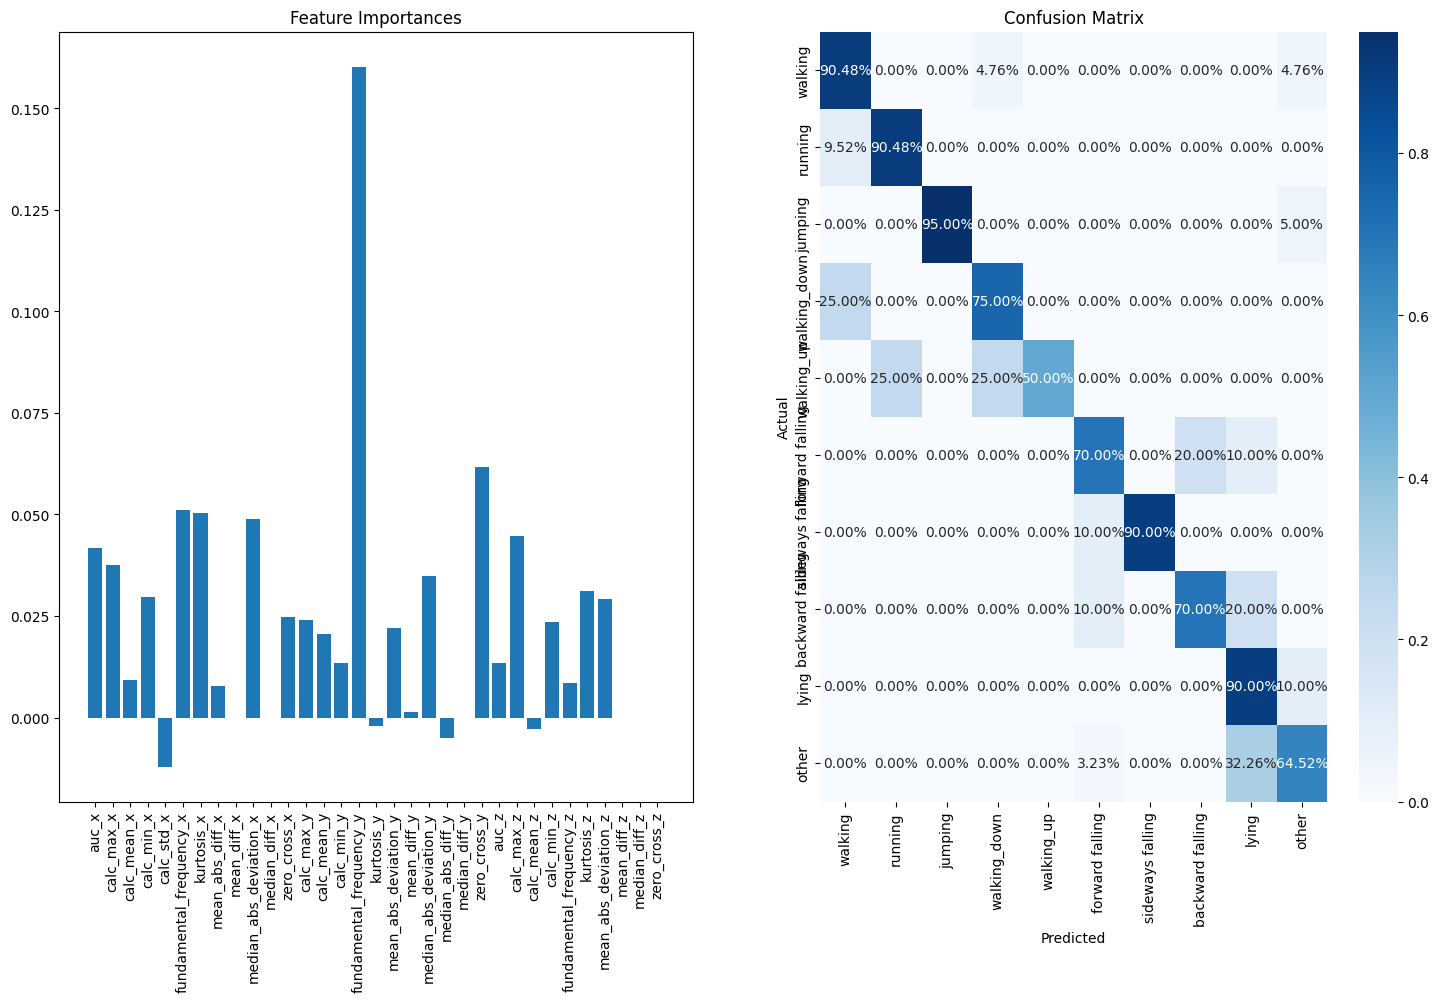

In [51]:
# Plot the feature importances and confusion matrix side by side
plot_importance_confusion(importances, X_train, y_predict, activities)


#### Feature importance selection

In [52]:
# Select the top k features
k = 15
top_k_indices = importances.argsort()[::-1][:k]
top_k_features = X_train.columns[top_k_indices]

# Train the Naive Bayes classifier using the top k features
bayes_classifier = GaussianNB()
bayes_classifier.fit(X_train[top_k_features], Y_train)

# Predict test data
y_predict = bayes_classifier.predict(X_test[top_k_features])

# Get the classification report and evaluate the model using cross-validation on the training set with top k features
evaluate_model_top_k(bayes_classifier, X_train_scaled,
                     y_predict, Y_train, Y_test, activities, top_k_indices)


                  precision    recall  f1-score   support

         walking       0.90      0.90      0.90        21
         running       0.91      0.95      0.93        21
         jumping       1.00      0.90      0.95        20
    walking_down       0.80      1.00      0.89         4
      walking_up       1.00      0.50      0.67         4
 forward falling       0.55      0.60      0.57        10
sideways falling       1.00      0.90      0.95        10
backward falling       0.75      0.60      0.67        10
           lying       0.38      0.60      0.46        10
           other       0.79      0.74      0.77        31

        accuracy                           0.80       141
       macro avg       0.81      0.77      0.78       141
    weighted avg       0.83      0.80      0.81       141

Accuracy: 80.1418439716312%
Cross-validation scores: [0.86363636 0.81818182 0.84615385 0.84615385 0.81538462]
Mean cross-validation score: 0.8379020979020979


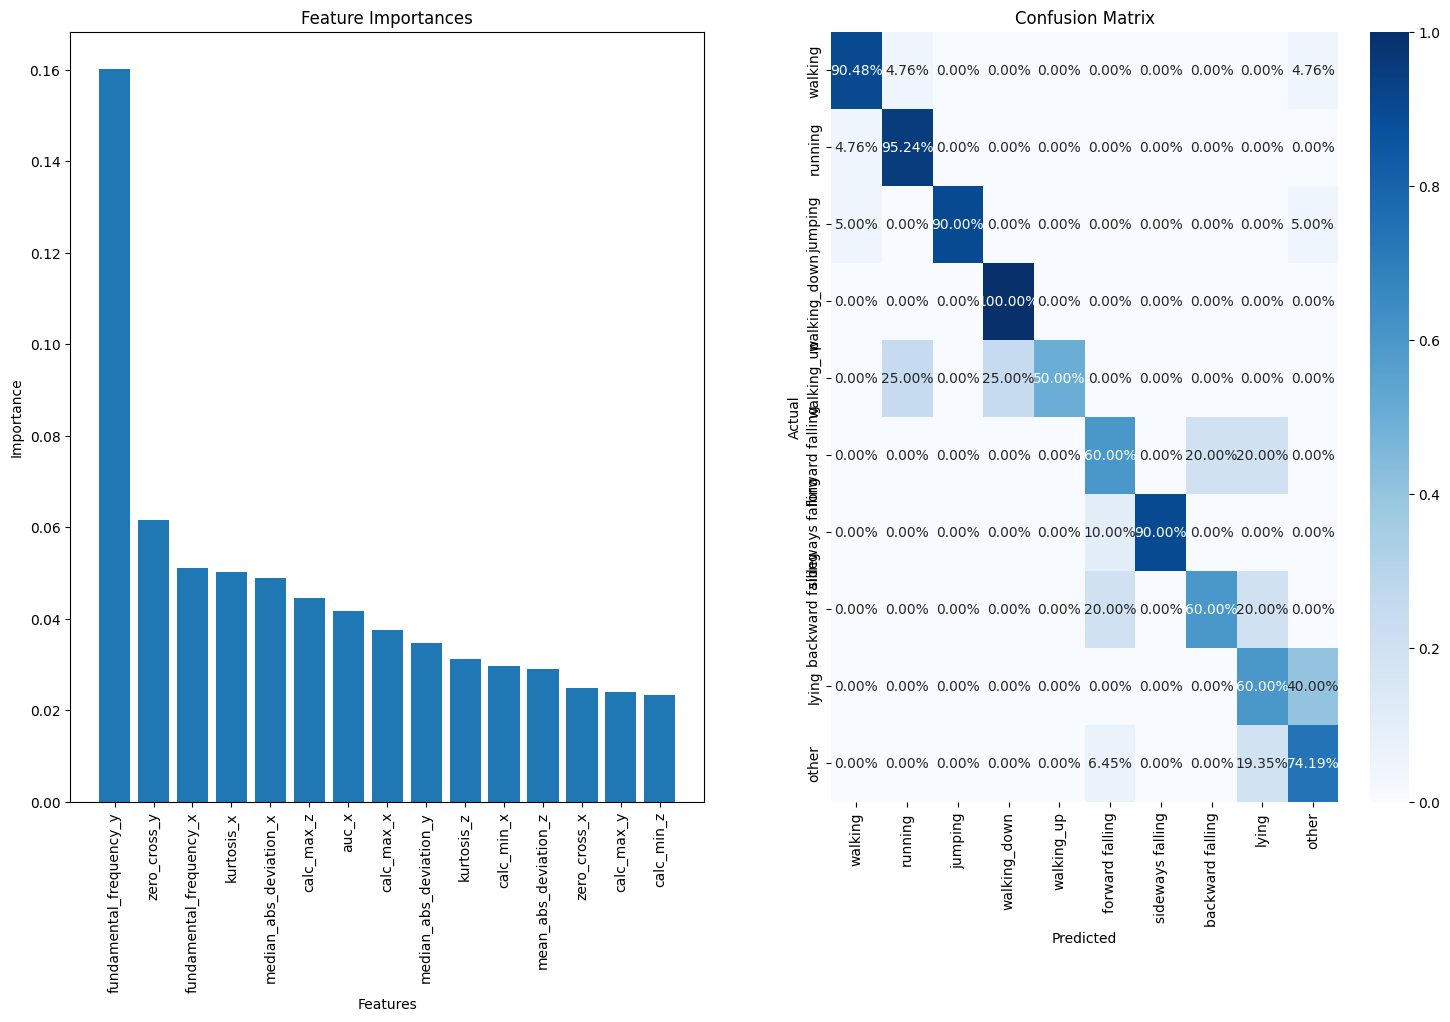

In [53]:
# Plot the feature importances and confusion matrix with top k features side by side
plot_importance_confusion_top_k(
    importances, X_train, y_predict, activities, top_k_features, top_k_indices, k)


# 4.3 Ensemble classifier

                  precision    recall  f1-score   support

         walking       0.95      0.95      0.95        21
         running       1.00      1.00      1.00        21
         jumping       1.00      0.95      0.97        20
    walking_down       1.00      1.00      1.00         4
      walking_up       1.00      0.75      0.86         4
 forward falling       0.80      0.80      0.80        10
sideways falling       1.00      1.00      1.00        10
backward falling       0.78      0.70      0.74        10
           lying       0.75      0.90      0.82        10
           other       0.91      0.94      0.92        31

        accuracy                           0.92       141
       macro avg       0.92      0.90      0.91       141
    weighted avg       0.92      0.92      0.92       141

Accuracy: 92.19858156028369%
Cross-validation scores: [0.95454545 0.87878788 0.89230769 0.89230769 0.87692308]
Mean cross-validation score: 0.898974358974359


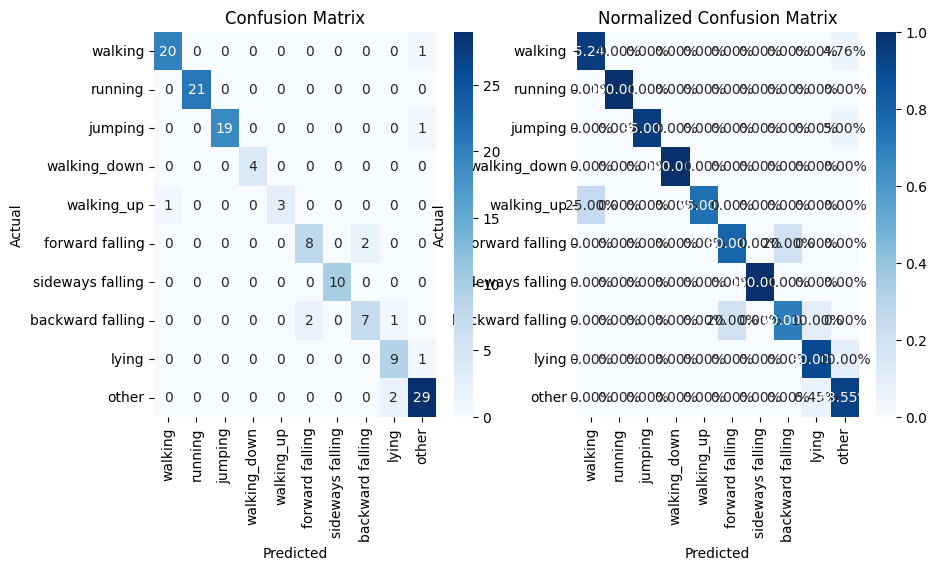

In [54]:
# Define the classifiers
knn = knn_classifier
svm = svm_classifier
rfc = random_forest_classifier
logreg = logistic_regression_classifier

# Define the ensemble model
ensemble_model = VotingClassifier(
    estimators=[('svm', svm), ('rfc', rfc), ('logreg', logreg)], voting='hard')

# Train the ensemble model
ensemble_model.fit(X_train_scaled, Y_train)

# Predict test data
y_predict = ensemble_model.predict(X_test_scaled)

# Get the classification report and evaluate the model using cross-validation on the training set
evaluate_model(ensemble_model, X_train_scaled,
               y_predict, Y_train, Y_test, activities)

conf_matrix = confusion_matrix(Y_test, y_predict)
# Plot the confusion matrix
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')
axs[0].set_title('Confusion Matrix')
axs[0].set_xticklabels(activities, rotation=90)
axs[0].set_yticklabels(activities, rotation=0)

cm = confusion_matrix(Y_test, y_predict, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', ax=axs[1])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')
axs[1].set_title('Normalized Confusion Matrix')
axs[1].set_xticklabels(activities, rotation=90)
axs[1].set_yticklabels(activities, rotation=0)

plt.show()


In [55]:
# Define the classifiers
knn = knn_classifier
svm = svm_classifier
rfc = random_forest_classifier
logreg = logistic_regression_classifier

# Define the ensemble model
ensemble_model = VotingClassifier(
    estimators=[('rfc', rfc), ('logreg', logreg)], voting='soft')

# Define the boosting model
boosting_model = AdaBoostClassifier(
    base_estimator=rfc, n_estimators=50, learning_rate=1.0, algorithm="SAMME")

# Train the boosting model
boosting_model.fit(X_train_scaled, Y_train)

# Predict test data
y_predict = boosting_model.predict(X_test_scaled)

# Get the classification report and evaluate the model using cross-validation on the training set
evaluate_model(boosting_model, X_train_scaled,
               y_predict, Y_train, Y_test, activities)


                  precision    recall  f1-score   support

         walking       0.95      0.95      0.95        21
         running       1.00      1.00      1.00        21
         jumping       1.00      0.95      0.97        20
    walking_down       1.00      0.75      0.86         4
      walking_up       1.00      1.00      1.00         4
 forward falling       0.89      0.80      0.84        10
sideways falling       1.00      1.00      1.00        10
backward falling       0.82      0.90      0.86        10
           lying       0.90      0.90      0.90        10
           other       0.91      0.97      0.94        31

        accuracy                           0.94       141
       macro avg       0.95      0.92      0.93       141
    weighted avg       0.95      0.94      0.94       141

Accuracy: 94.32624113475178%
Cross-validation scores: [0.93939394 0.89393939 0.95384615 0.92307692 0.87692308]
Mean cross-validation score: 0.9174358974358974


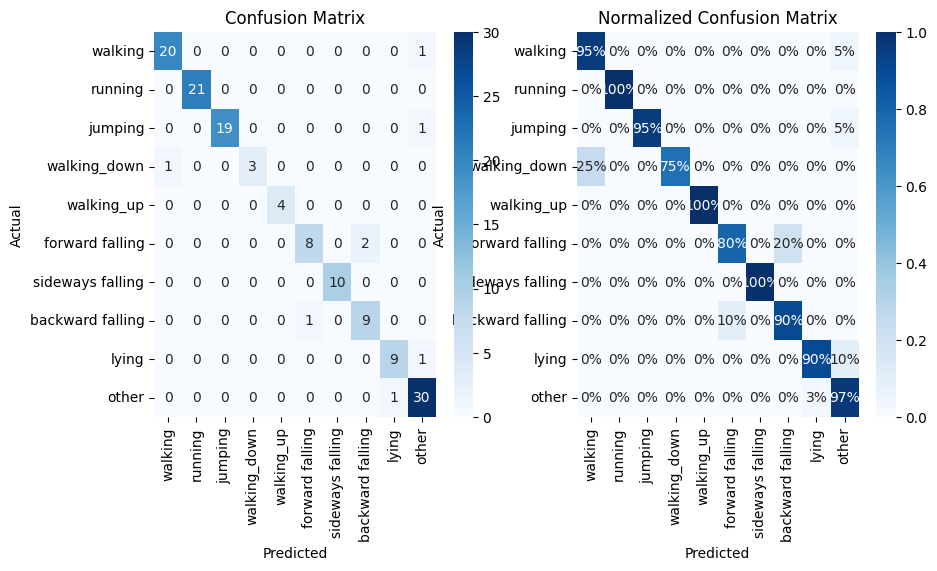

In [56]:
conf_matrix = confusion_matrix(Y_test, y_predict)
# Plot the confusion matrix
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')
axs[0].set_title('Confusion Matrix')
axs[0].set_xticklabels(activities, rotation=90)
axs[0].set_yticklabels(activities, rotation=0)

cm = confusion_matrix(Y_test, y_predict, normalize='true')
sns.heatmap(cm, annot=True, fmt='.0%', cmap='Blues', ax=axs[1])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')
axs[1].set_title('Normalized Confusion Matrix')
axs[1].set_xticklabels(activities, rotation=90)
axs[1].set_yticklabels(activities, rotation=0)

plt.show()


# 5. T-SNE visual

In [57]:
# Define the t-SNE model
tsne_model = TSNE(n_components=3, perplexity=30, random_state=42)

# Fit and transform the data to 3 dimensions
X_train_tsne = tsne_model.fit_transform(X_train_scaled)

# Define the interactive plot function


@interact(elev=(0, 90), azim=(-180, 180))
def plot_3d(elev=30, azim=30):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(
        X_train_tsne[:, 0], X_train_tsne[:, 1], X_train_tsne[:, 2], c=Y_train)
    ax.set_title('t-SNE Clustering of X_train Data')
    ax.set_xlabel('t-SNE Feature 1')
    ax.set_ylabel('t-SNE Feature 2')
    ax.set_zlabel('t-SNE Feature 3')
    ax.view_init(elev=elev, azim=azim)
    plt.show()


c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


interactive(children=(IntSlider(value=30, description='elev', max=90), IntSlider(value=30, description='azim',…